# End result 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import Progbar

from tensorflow.keras import backend as K
from sklearn.utils.class_weight import compute_class_weight

import os
import datetime
import pickle
import sys
import warnings

# only grow GPU memory when needed
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)



os.environ['TF_USE_LEGACY_KERAS'] = 'True'

warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)

sns.set(style='darkgrid')
sns.mpl.rc('figure', figsize=(7, 5))
sns.mpl.rc('font', size = 12)

pd.set_option('display.max_columns', 100)

In [2]:
path = os.path.join('data', 'train.csv')
df = pd.read_csv(path, index_col=0)
df.head(10)

var1  var2  var3         var4     var5  var6  var7  var8  var9  var10  \
ID                                                                              
1   0.766127    45     2     0.802982   9120.0    13     0     6     0    2.0   
2   0.957151    40     0     0.121876   2600.0     4     0     0     0    1.0   
3   0.658180    38     1     0.085113   3042.0     2     1     0     0    0.0   
4   0.233810    30     0     0.036050   3300.0     5     0     0     0    0.0   
5   0.907239    49     1     0.024926  63588.0     7     0     1     0    0.0   
6   0.213179    74     0     0.375607   3500.0     3     0     1     0    1.0   
7   0.305682    57     0  5710.000000      NaN     8     0     3     0    0.0   
8   0.754464    39     0     0.209940   3500.0     8     0     0     0    0.0   
9   0.116951    27     0    46.000000      NaN     2     0     0     0    NaN   
10  0.189169    57     0     0.606291  23684.0     9     0     4     0    2.0   

    TARGET  
ID          
1        1  
2        0  
3        0  
4        0  
5        0  
6        0  
7        0  
8        0  
9        0  
10       0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 104998 entries, 1 to 104998
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   var1    104998 non-null  float64
 1   var2    104998 non-null  int64  
 2   var3    104998 non-null  int64  
 3   var4    104998 non-null  float64
 4   var5    84226 non-null   float64
 5   var6    104998 non-null  int64  
 6   var7    104998 non-null  int64  
 7   var8    104998 non-null  int64  
 8   var9    104998 non-null  int64  
 9   var10   102238 non-null  float64
 10  TARGET  104998 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 9.6 MB


In [4]:
df.describe()

var1           var2           var3           var4  \
count  104998.000000  104998.000000  104998.000000  104998.000000   
mean        6.073156      52.261014       0.422665     354.627892   
std       257.859625      14.768987       4.221443    2104.703046   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.030002      41.000000       0.000000       0.175067   
50%         0.155936      52.000000       0.000000       0.366162   
75%         0.561917      63.000000       0.000000       0.866584   
max     50708.000000     107.000000      98.000000  329664.000000   

               var5           var6           var7           var8  \
count  8.422600e+04  104998.000000  104998.000000  104998.000000   
mean   6.636739e+03       8.442294       0.268386       1.018696   
std    1.359493e+04       5.136260       4.197747       1.134364   
min    0.000000e+00       0.000000       0.000000       0.000000   
25%    3.400000e+03       5.000000       0.000000       0.000000   
50%    5.400000e+03       8.000000       0.000000       1.000000   
75%    8.228000e+03      11.000000       0.000000       2.000000   
max    3.008750e+06      58.000000      98.000000      54.000000   

                var9          var10         TARGET  
count  104998.000000  102238.000000  104998.000000  
mean        0.242186       0.757957       0.066725  
std         4.184389       1.116196       0.249546  
min         0.000000       0.000000       0.000000  
25%         0.000000       0.000000       0.000000  
50%         0.000000       0.000000       0.000000  
75%         0.000000       1.000000       0.000000  
max        98.000000      20.000000       1.000000

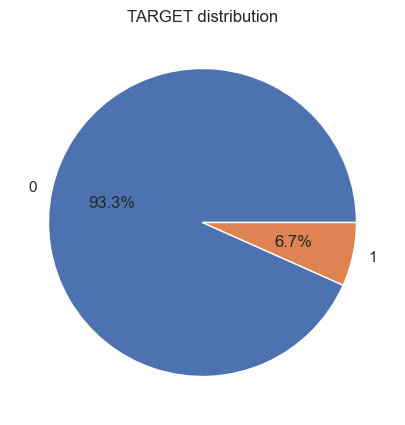

In [5]:
plt.title("TARGET distribution")
plt.pie(df['TARGET'].value_counts(), 
        labels=['0', '1'], 
        autopct='%1.1f%%')
plt.show()

**Unbalanced dataset**, this is highly important and the reason why
we are scoring with respect to the F1 score.

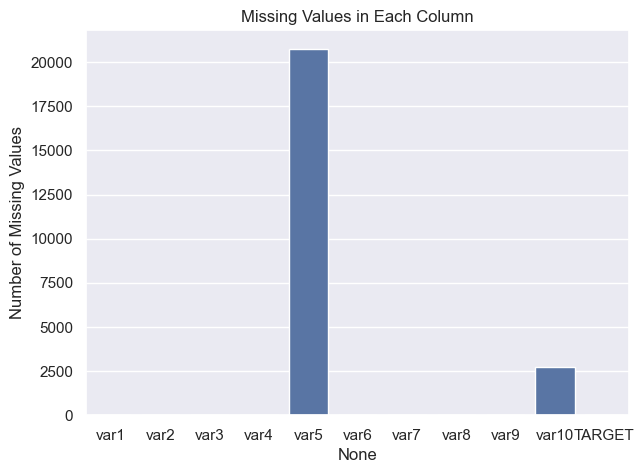

In [6]:
sns.barplot(x=df.columns, y=df.isna().sum())
plt.ylabel('Number of Missing Values')
plt.title('Missing Values in Each Column')
plt.show()

## Handling Nan values & Visualizing data
 
We can use:

- `df.dropna()`: Drop rows with Nan values
- `.ffill` or `.bfill` to fill Nan values with the previous or next value
- `df.fillna()`: Fill Nan values with a specific value

I need some visualization to understand the data better. 

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 TARGET 

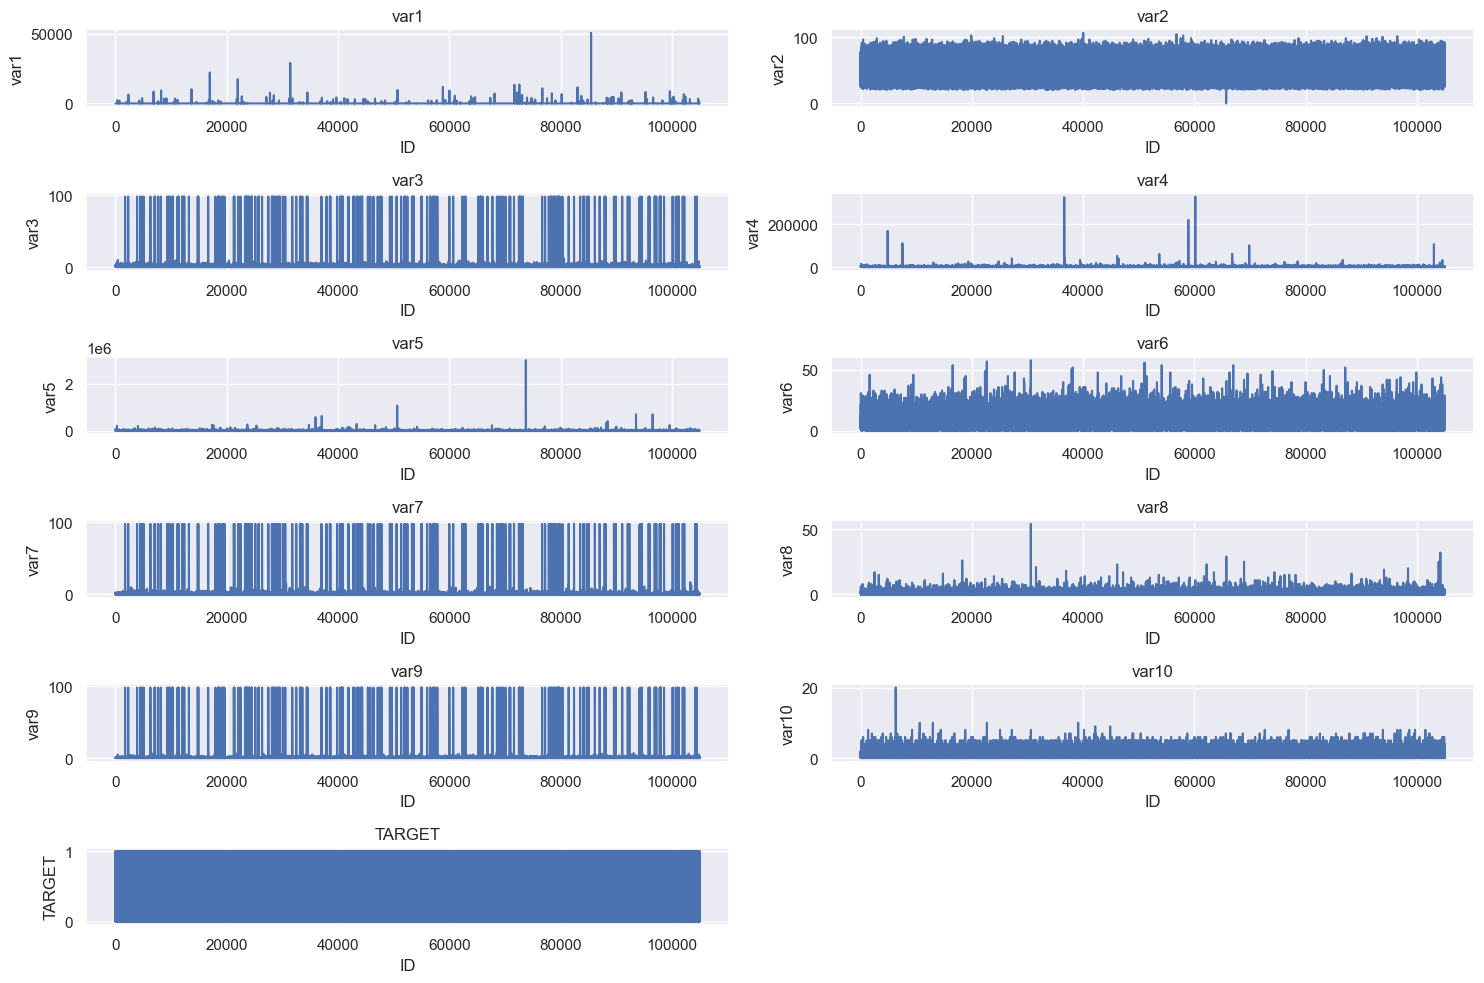

In [7]:
min_idx = 0
max_idx = ( len(df) - 1 ) 

plt.figure(figsize=(15, 10))
for i, col in enumerate(df.columns):
    print(col, end = " ")
    ax1 = plt.subplot(6, 2, i + 1)
    data = df.iloc[min_idx:max_idx]
    sns.lineplot(data=data, x=data.index, y=col,  ax=ax1) 
    plt.title(col)  
plt.tight_layout()
plt.show()

Not much information can be seen from the graphs, except some big outliers

In [8]:
nan_indices = df.isna().stack()[lambda x: x].index.tolist()
print(nan_indices)

[(7, 'var5'), (9, 'var5'), (9, 'var10'), (17, 'var5'), (33, 'var5'), (42, 'var5'), (53, 'var5'), (59, 'var5'), (63, 'var5'), (72, 'var5'), (87, 'var5'), (93, 'var5'), (97, 'var5'), (97, 'var10'), (101, 'var5'), (110, 'var5'), (110, 'var10'), (116, 'var5'), (119, 'var5'), (125, 'var5'), (131, 'var5'), (142, 'var5'), (144, 'var5'), (160, 'var5'), (160, 'var10'), (162, 'var5'), (167, 'var5'), (172, 'var5'), (180, 'var5'), (182, 'var5'), (184, 'var5'), (188, 'var5'), (193, 'var5'), (199, 'var5'), (208, 'var5'), (211, 'var5'), (215, 'var5'), (216, 'var5'), (236, 'var5'), (239, 'var5'), (239, 'var10'), (243, 'var5'), (260, 'var5'), (262, 'var5'), (264, 'var5'), (264, 'var10'), (285, 'var5'), (285, 'var10'), (292, 'var5'), (321, 'var5'), (322, 'var5'), (332, 'var5'), (347, 'var5'), (348, 'var5'), (352, 'var5'), (354, 'var5'), (355, 'var5'), (357, 'var5'), (359, 'var5'), (365, 'var5'), (368, 'var5'), (369, 'var5'), (373, 'var5'), (382, 'var5'), (382, 'var10'), (383, 'var5'), (383, 'var10'), (3

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 TARGET 

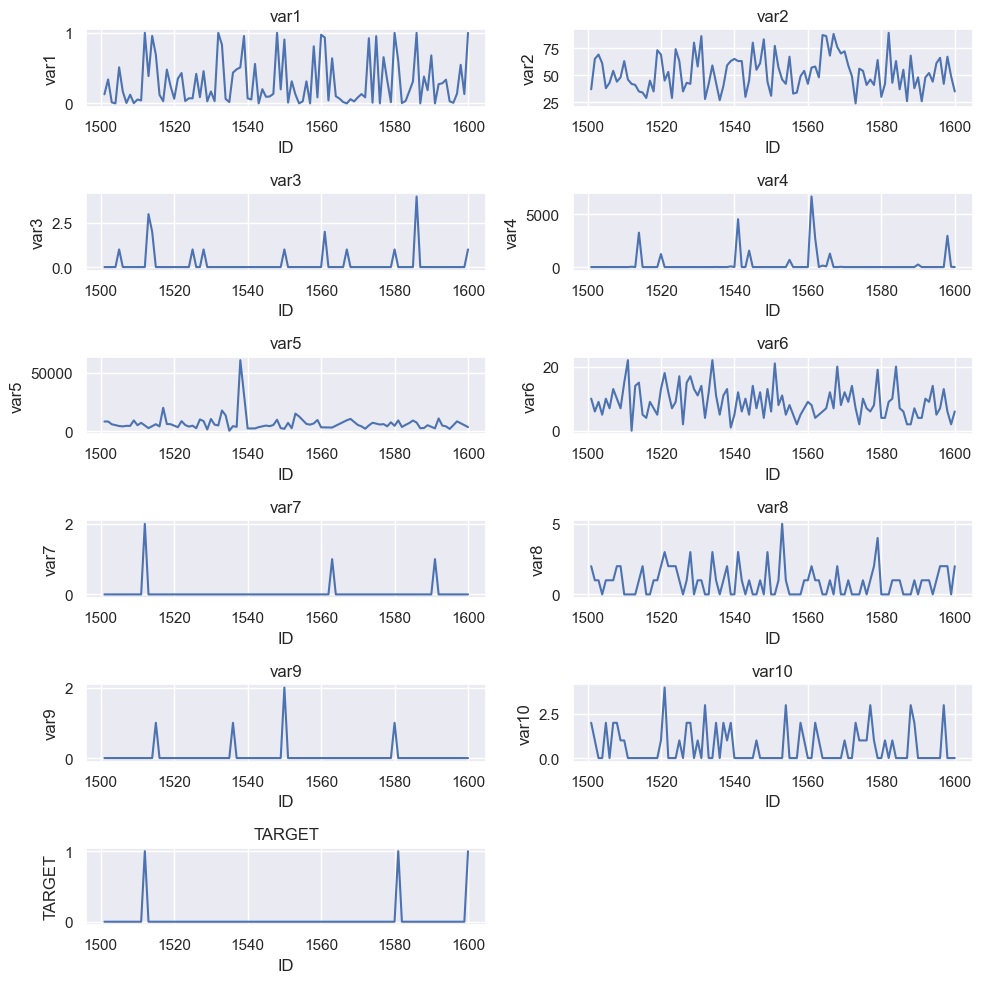

In [9]:
min_idx = 1500
max_idx = 1600

plt.figure(figsize=(10, 10))
for i, col in enumerate(df.columns):
    print(col, end = " ")
    ax1 = plt.subplot(6, 2, i + 1)
    data = df.iloc[min_idx:max_idx]
    sns.lineplot(data=data, x=data.index, y=col,  ax=ax1) 
    plt.title(col) 
plt.tight_layout()
plt.show()

In [10]:
df.loc[:, 'var10'].median()

0.0

From what i can observe, the `var5` is more of a time series, and the `var10` doesn't seem to have a time series pattern over time.

So to deal with Nan values, for `var5` i will use `.ffill` and for `var10` i will use `median` to fill the Nan values.

In [11]:
df.loc[:, 'var10'] = df.loc[:, 'var10'].fillna(df.loc[:, 'var10'].median())
df.loc[:, 'var5'].ffill(inplace=True)

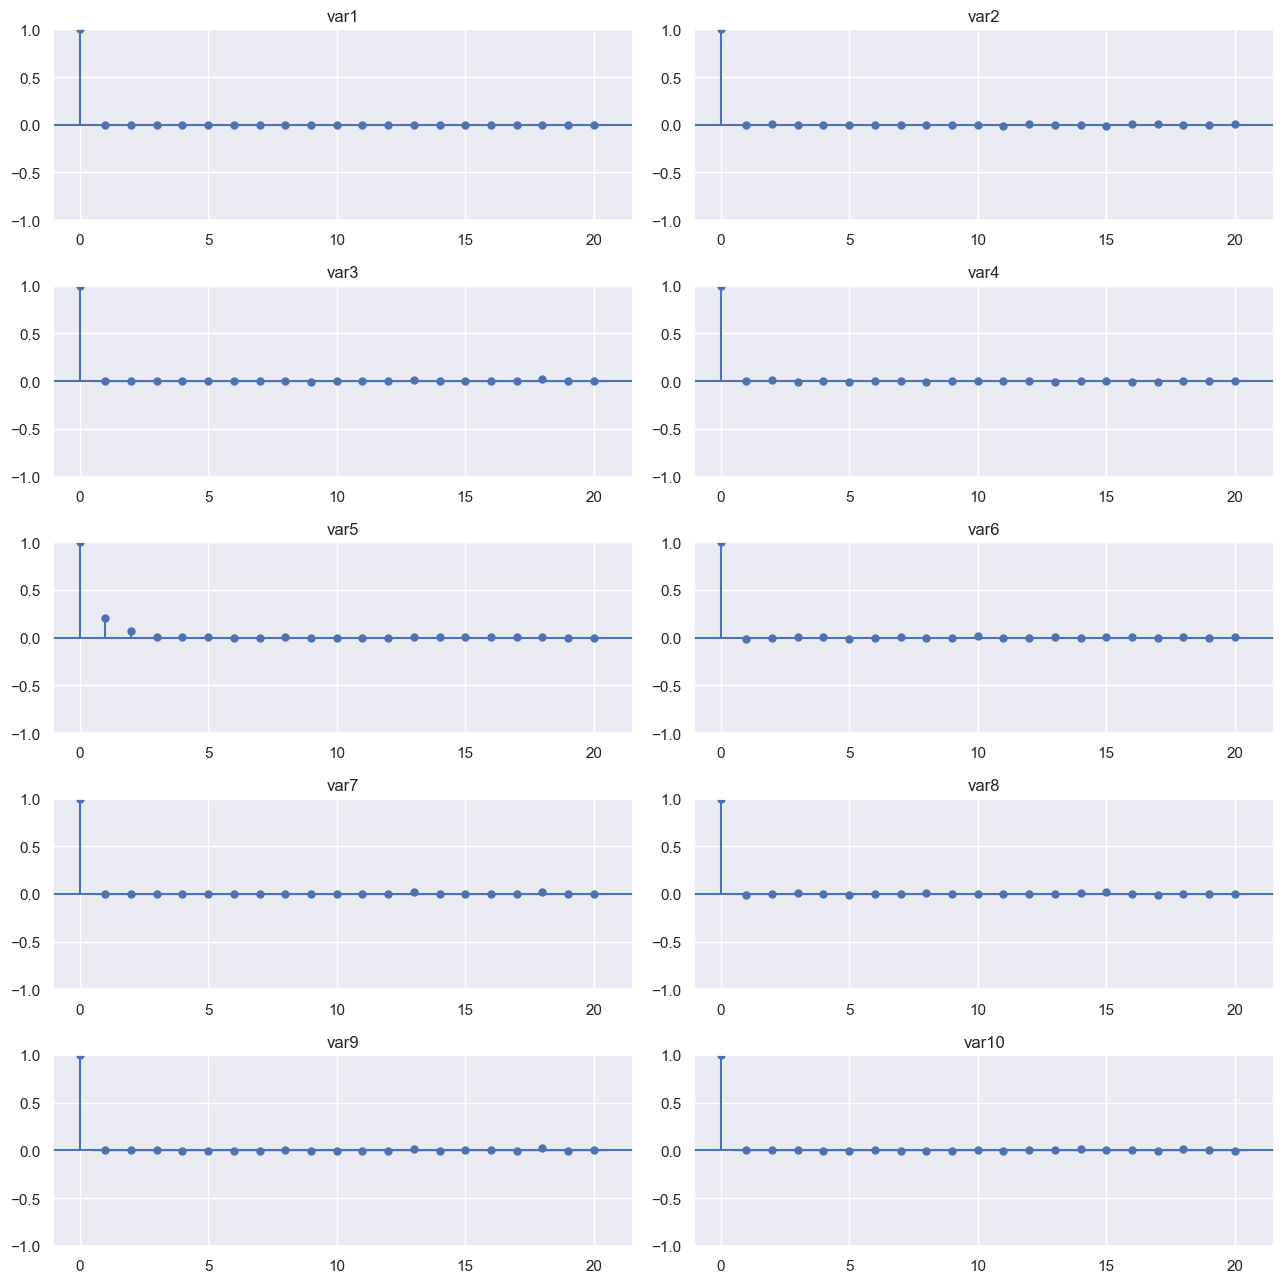

In [12]:
from statsmodels.graphics.tsaplots import plot_acf

min_idx = 0
max_idx = ( len(df) - 1 ) // 4
data = df.iloc[min_idx:max_idx]

fig, axes = plt.subplots(5, 2, figsize=(13, 13))
axes = axes.flatten()
for i, col in enumerate(data.drop(columns="TARGET").columns):
    if col == 'target':
        continue
    plot_acf(data[col], ax=axes[i], lags=20)
    axes[i].set_title(col)
plt.tight_layout()
plt.show()   

I want to see if the time series has non-linear dependencies.

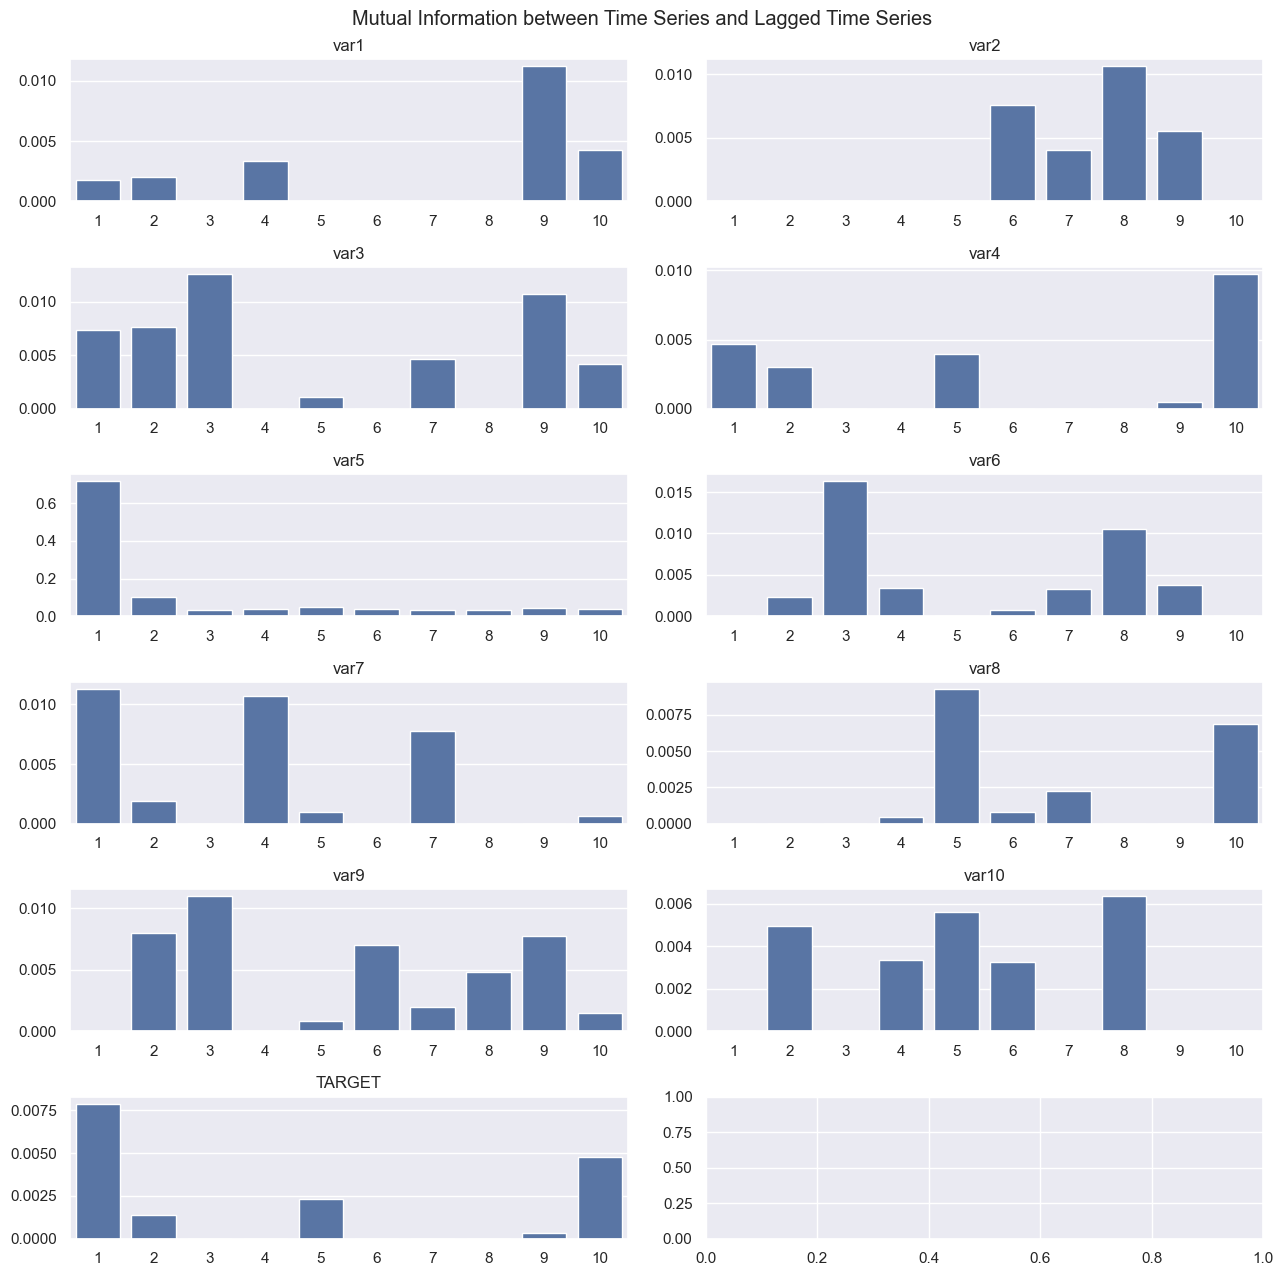

In [13]:
from sklearn.feature_selection import mutual_info_regression

min_idx = 0
max_idx = ( len(df) - 1 ) // 8
data = df.iloc[min_idx:max_idx]

lags = 10

def mutual_info_time_series(time_serie, max_lag=10):
    mi_scores = []
    for lag in range(1, max_lag + 1):
        mi = mutual_info_regression(time_serie[:-lag].reshape(-1,1), time_serie[lag:].reshape(-1,1))
        mi_scores.append(mi[0])
    return mi_scores

mutual_info_corr = [
    mutual_info_time_series(data[col].values, max_lag = lags) for col in data.columns
]

fig, axes = plt.subplots(6, 2, figsize=(13, 13))
axes = axes.flatten()
for i, col in enumerate(data.columns):
    sns.barplot(x=range(1, lags + 1), y=mutual_info_corr[i], ax=axes[i])
    axes[i].set_title(col)
fig.suptitle('Mutual Information between Time Series and Lagged Time Series')
plt.tight_layout()
plt.show() 

Hurst Exponent is a good way to measure the long-term memory of a time series.

- If 𝐻 > 0.5, the series has long-term positive autocorrelation (trending behavior).
- If H<0.5, the series is mean-reverting (switching between high and low values).
- If H=0.5, the series is a random walk (Brownian motion).


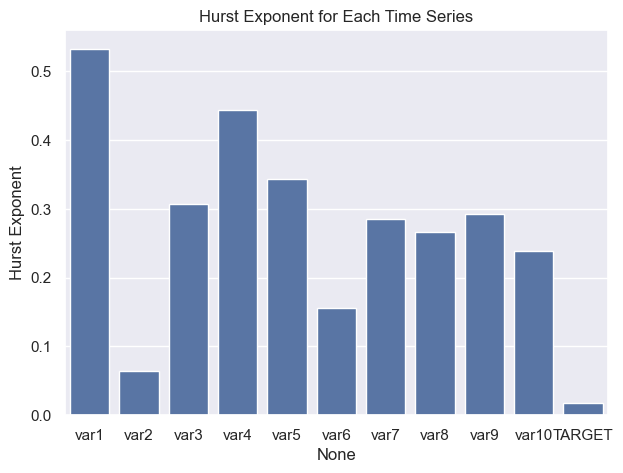

In [14]:
from hurst import compute_Hc

min_idx = 0
max_idx = ( len(df) - 1 ) // 4
data = df.iloc[min_idx:max_idx]

hurst_exponents = []
for col in data.columns:
    H, _, _ = compute_Hc(data[col], simplified=True)
    hurst_exponents.append(H)

sns.barplot(x=data.columns, y=hurst_exponents)
plt.ylabel('Hurst Exponent')
plt.title('Hurst Exponent for Each Time Series')
plt.show()    

## Feature Engineering

### Mutual information with the target

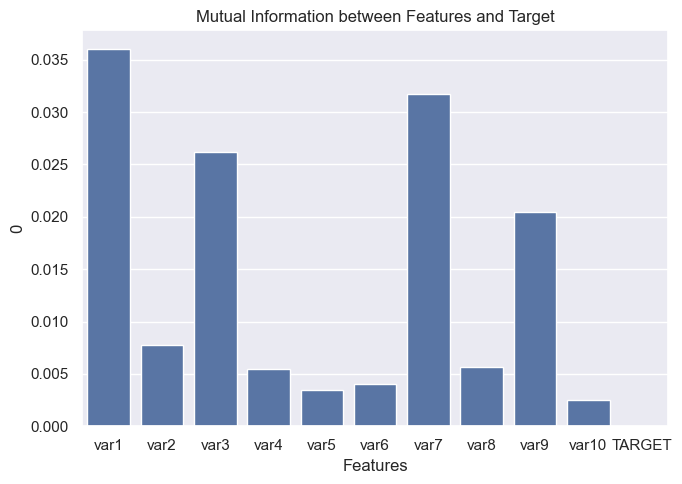

In [15]:
from sklearn.feature_selection import mutual_info_classif

mi_matrix = pd.DataFrame(columns=df.columns)

for col1 in df.columns:
    if col1 == 'TARGET':
        continue
    mi = mutual_info_classif(df[[col1]].values.reshape(-1, 1), df['TARGET'])
    mi_matrix[col1] = mi

plt.title('Mutual Information between Features and Target')
sns.barplot(data=mi_matrix.T, x=mi_matrix.columns, y=mi_matrix.iloc[0])
plt.xlabel('Features')
plt.tight_layout()
plt.show()

The features more important with respect to the target are also highly linearly correlated, except for `var1`

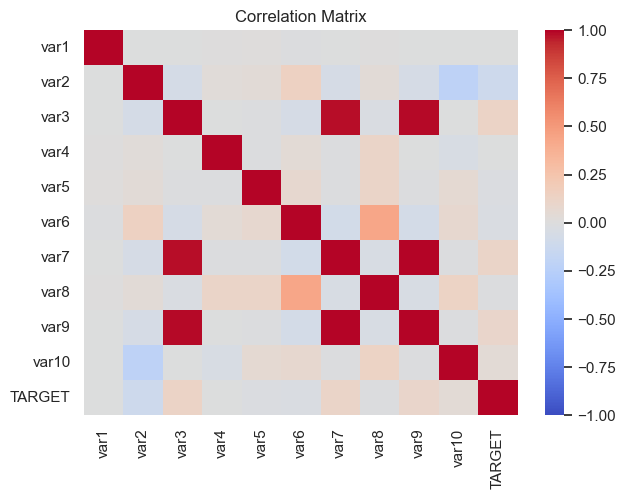

In [16]:
plt.title('Correlation Matrix')
sns.heatmap(df.corr(), annot=False, vmin=-1, vmax=1, center=0, cmap='coolwarm')
plt.show()

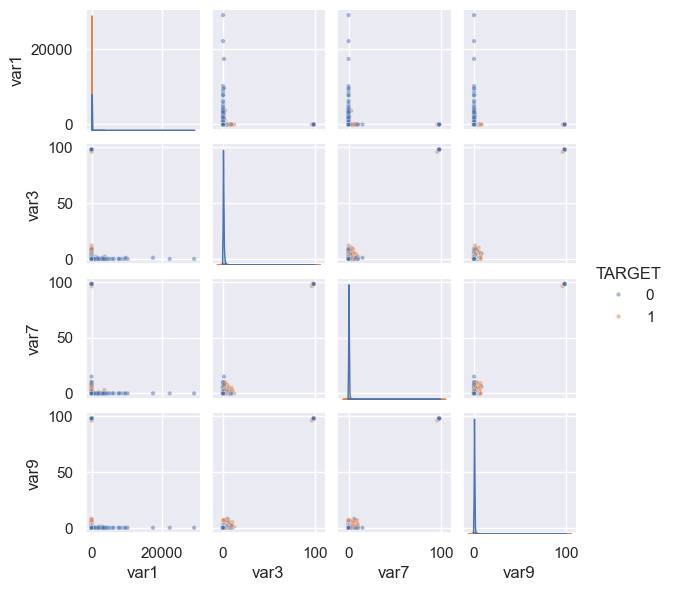

In [17]:
min_idx = 0
max_idx = ( len(df) - 1 ) // 2
columns = ['var1', 'var3', 'var7', 'var9', 'TARGET']

data = df.iloc[min_idx:max_idx][columns].copy()

sns.pairplot(
    data, 
    diag_kind='kde', 
    hue='TARGET',
    height=1.5, 
    aspect=1, 
    plot_kws={'alpha': 0.5, 's': 10},  
    diag_kws={'shade': True}
)

plt.show()

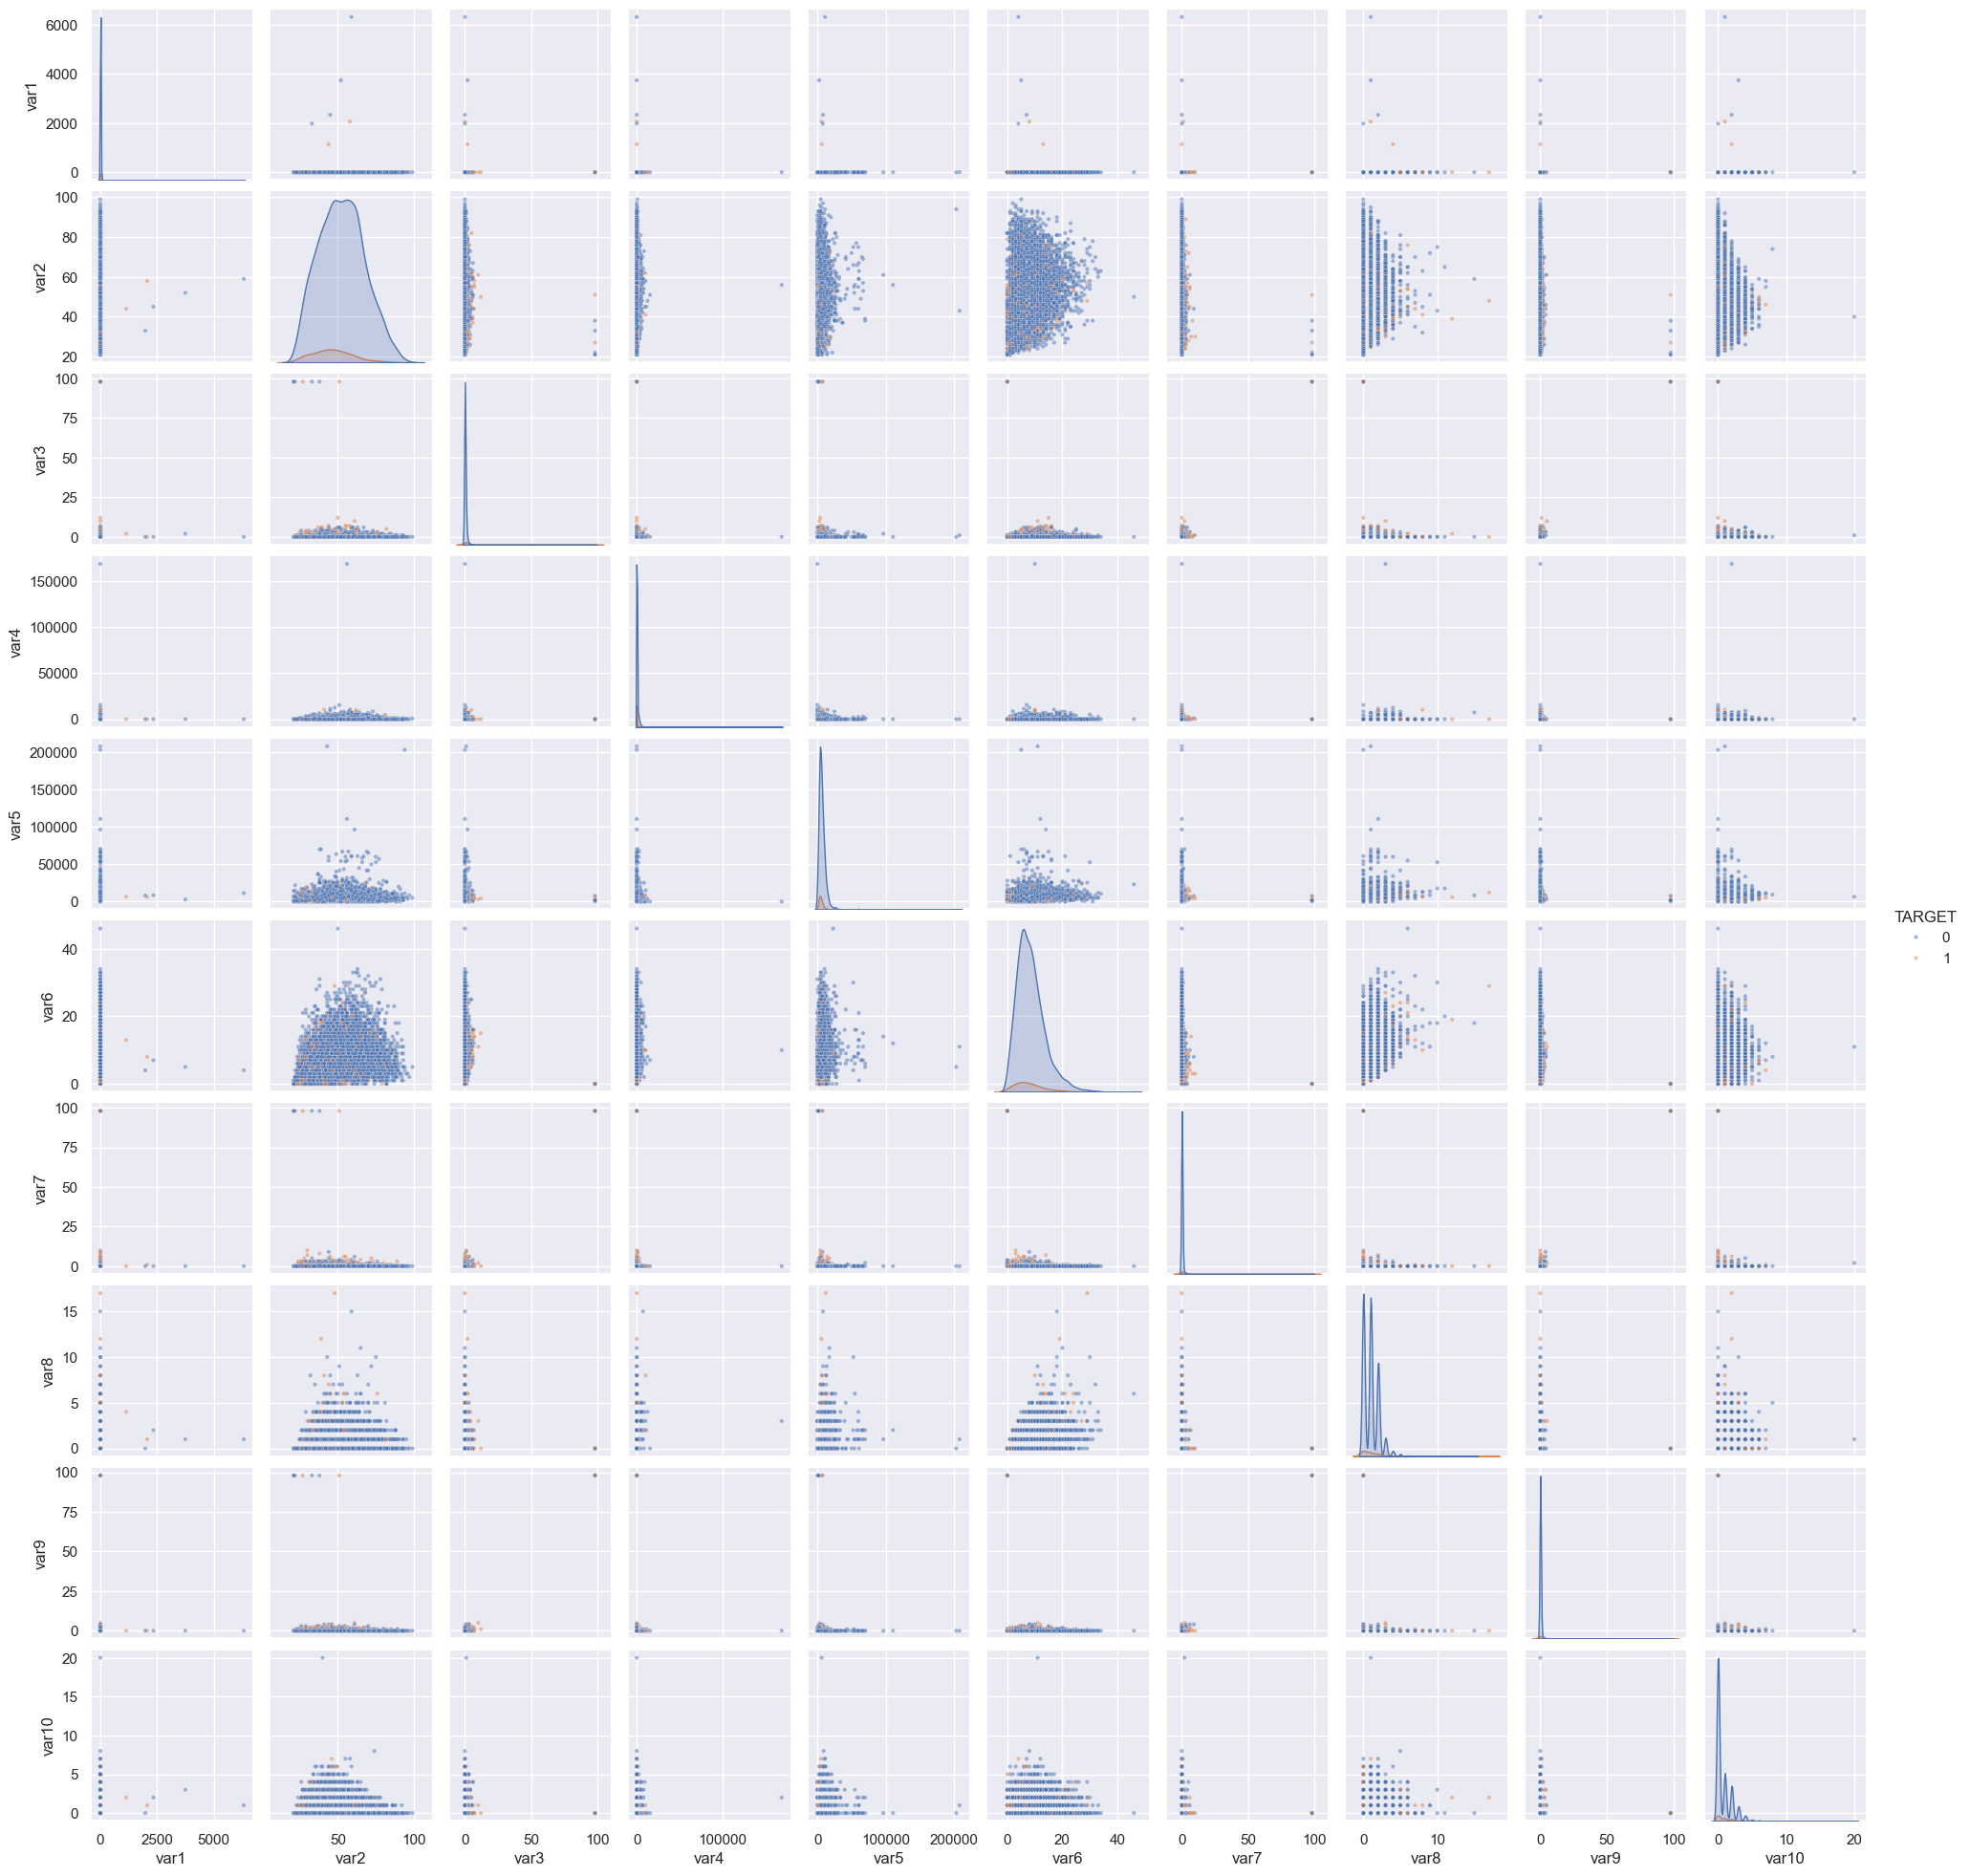

In [18]:
min_idx = 0
max_idx = ( len(df) - 1 ) // 16

data = df.iloc[min_idx:max_idx].copy()

sns.pairplot(
    data, 
    diag_kind='kde', 
    hue='TARGET',
    height=2, 
    aspect=1, 
    plot_kws={'alpha': 0.5, 's': 10},  
    diag_kws={'shade': True}
)

plt.show()

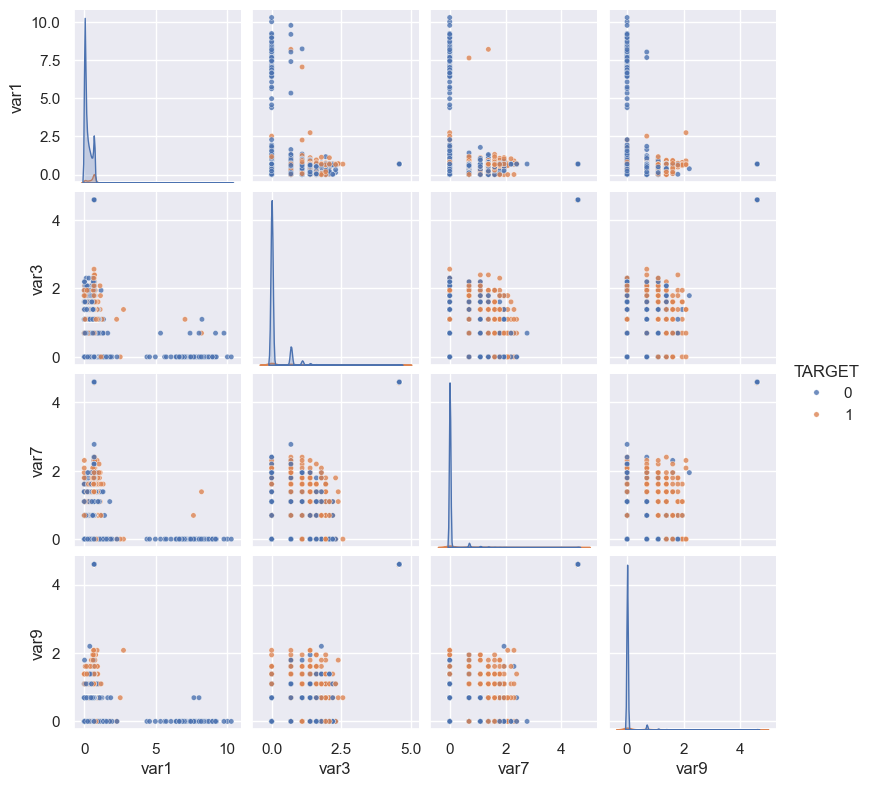

In [19]:
min_idx = 0
max_idx = ( len(df) - 1 ) // 2
columns = ['var1', 'var3', 'var7', 'var9', 'TARGET']

data = df.iloc[min_idx:max_idx][columns].copy()

for col in data.columns:
    if col == 'TARGET':
        continue
    elif data[col].min() < 1e-9:
        data[col] = np.log1p(data[col])
    else:
        data[col] = np.log(data[col])

sns.pairplot(
    data, 
    diag_kind='kde',
    hue='TARGET',
    height=2, 
    aspect=1, 
    plot_kws={'alpha': 0.8, 's': 15},  
    diag_kws={'shade': True}
)


plt.show()

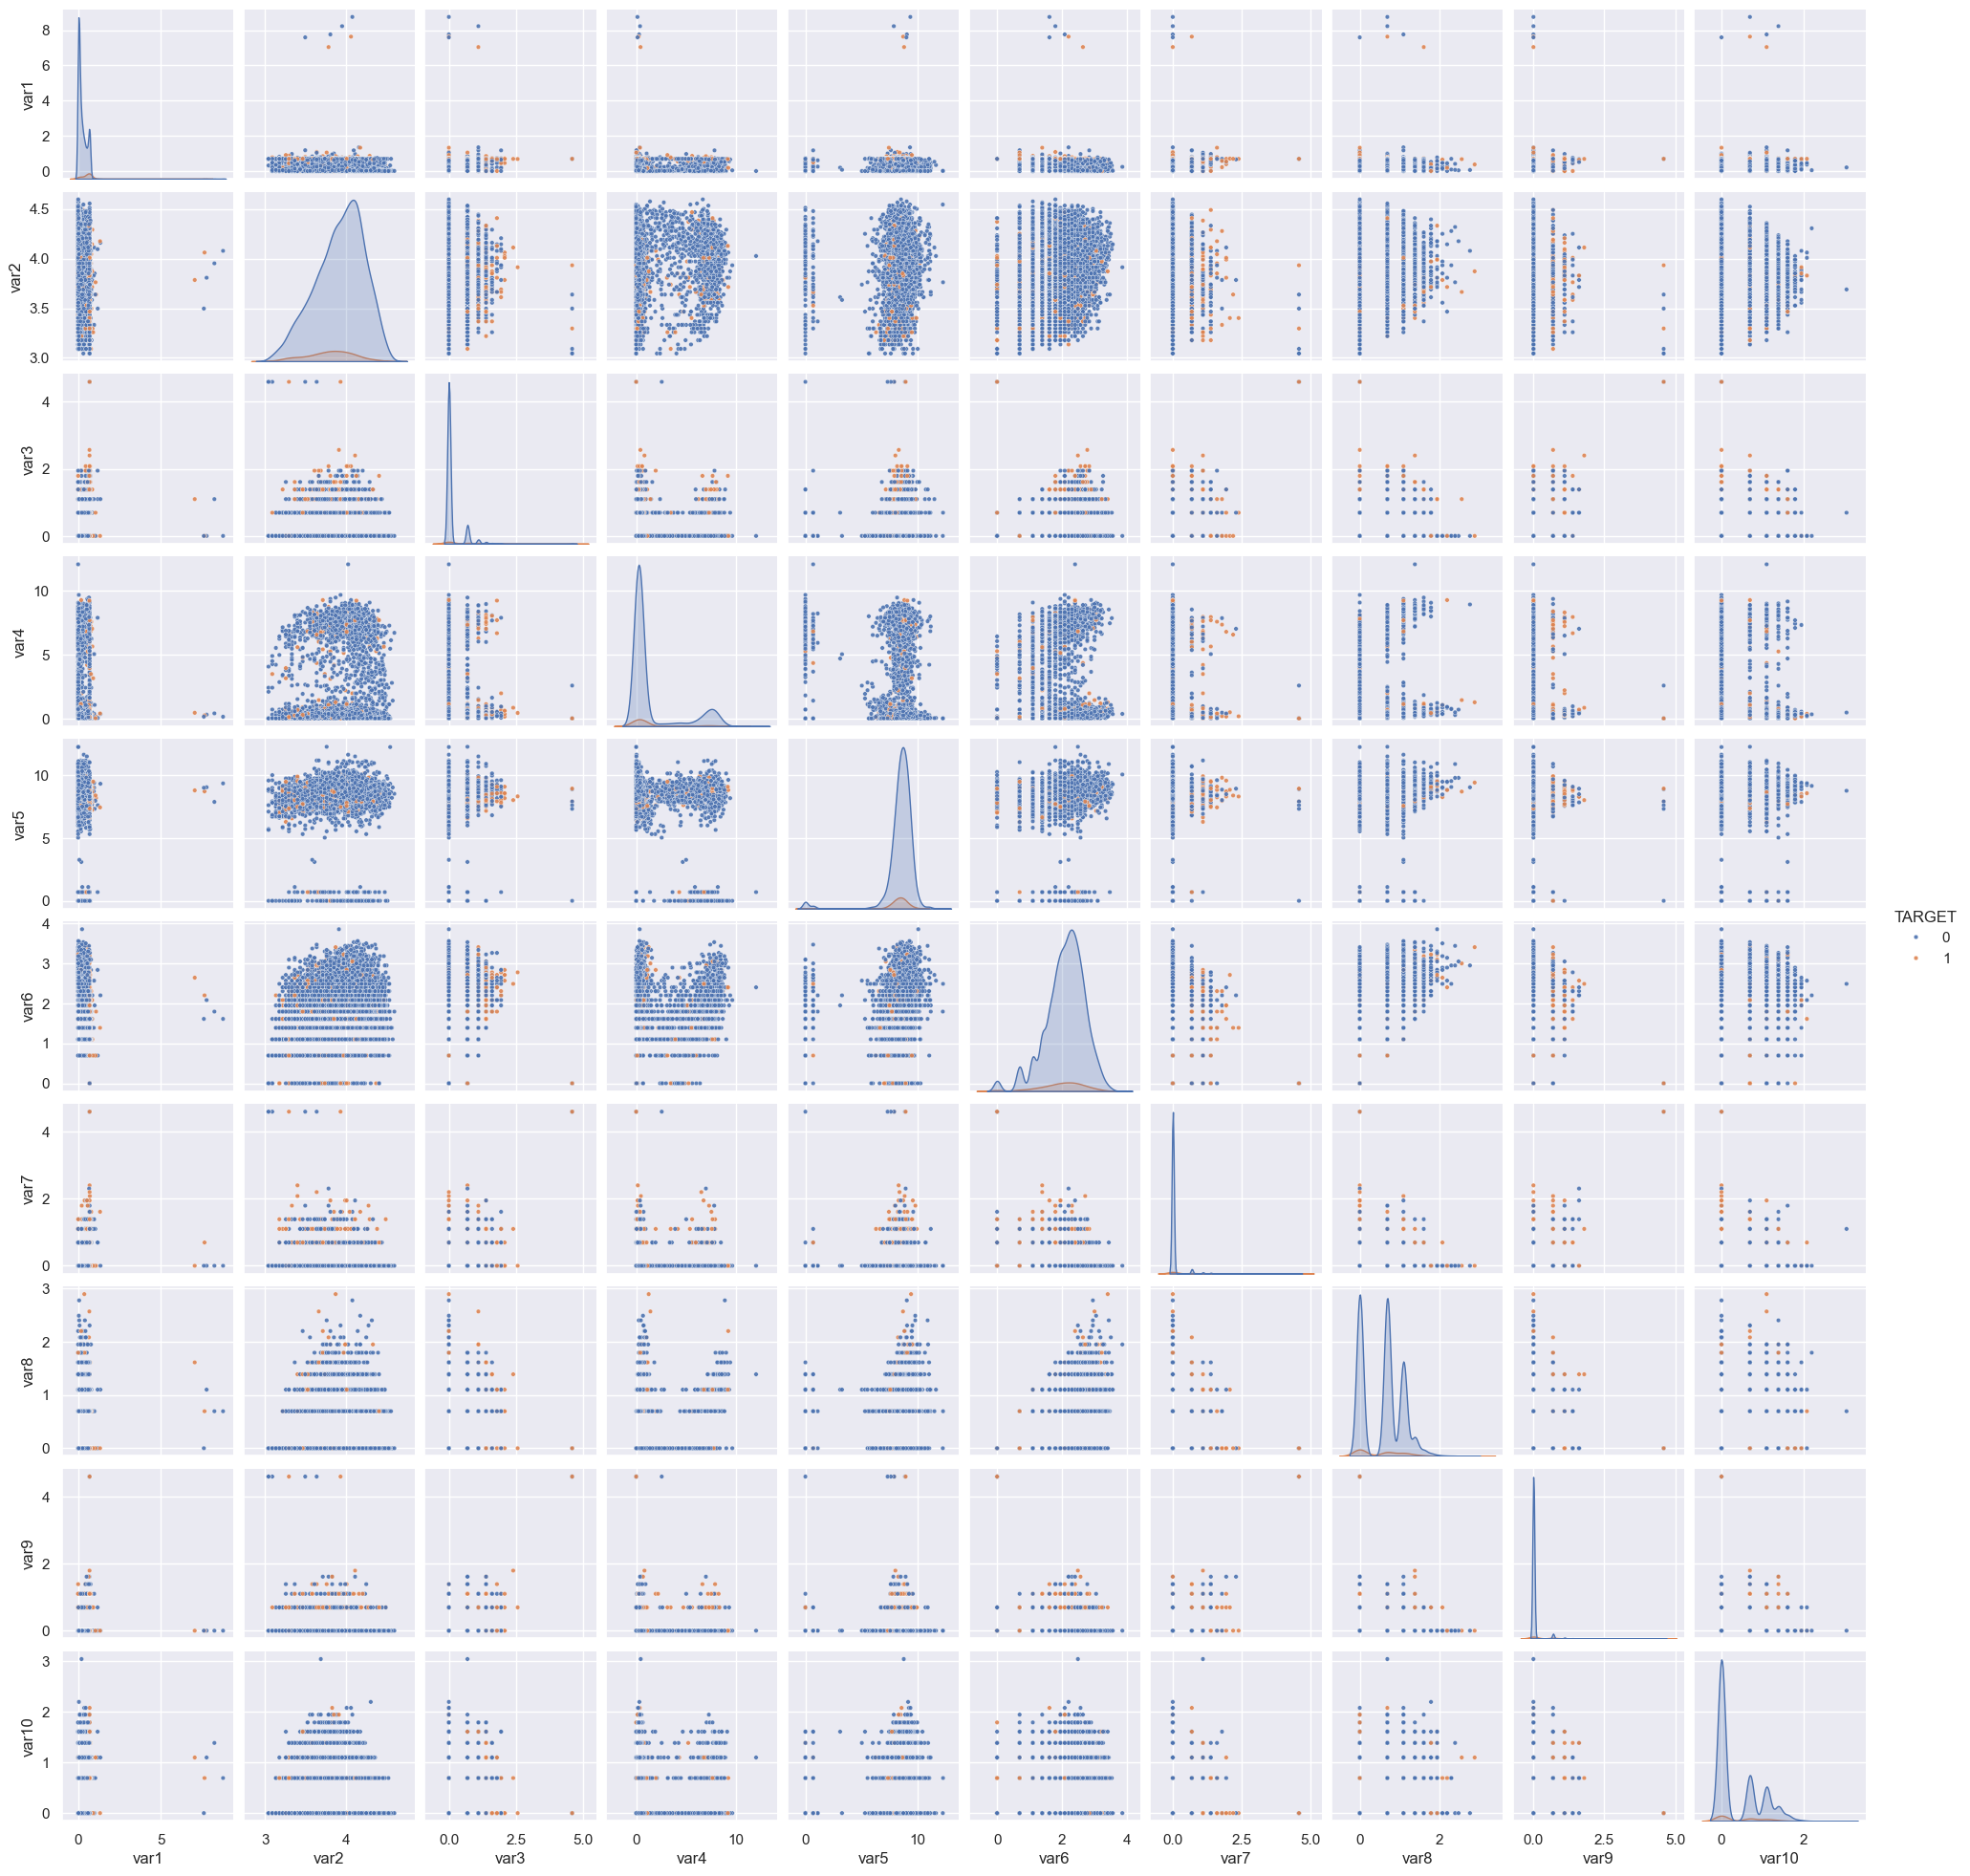

In [20]:
min_idx = 0
max_idx = ( len(df) - 1 ) // 16

data = df.iloc[min_idx:max_idx].copy()

for col in data.columns:
    if col == 'TARGET':
        continue
    elif data[col].min() < 1e-9:
        data[col] = np.log1p(data[col])
    else:
        data[col] = np.log(data[col])

sns.pairplot(
    data, 
    diag_kind='kde', 
    hue='TARGET',
    height=2, 
    aspect=1, 
    plot_kws={'alpha': 0.9, 's': 11},  
    diag_kws={'shade': True}
)

plt.show()

plt.show()

In [21]:
from sklearn.feature_selection import mutual_info_classif

data = df.copy()
for col in data.columns:
    if col == 'TARGET':
        continue
    elif data[col].min() < 1e-9:
        data[col] = np.log1p(data[col])
    else:
        data[col] = np.log(data[col])

mi_matrix_log = pd.DataFrame(columns=data.columns)

for col1 in data.columns:
    if col1 == 'TARGET':
        continue
    mi = mutual_info_classif(data[[col1]].values.reshape(-1, 1), data['TARGET'])
    mi_matrix_log[col1] = mi

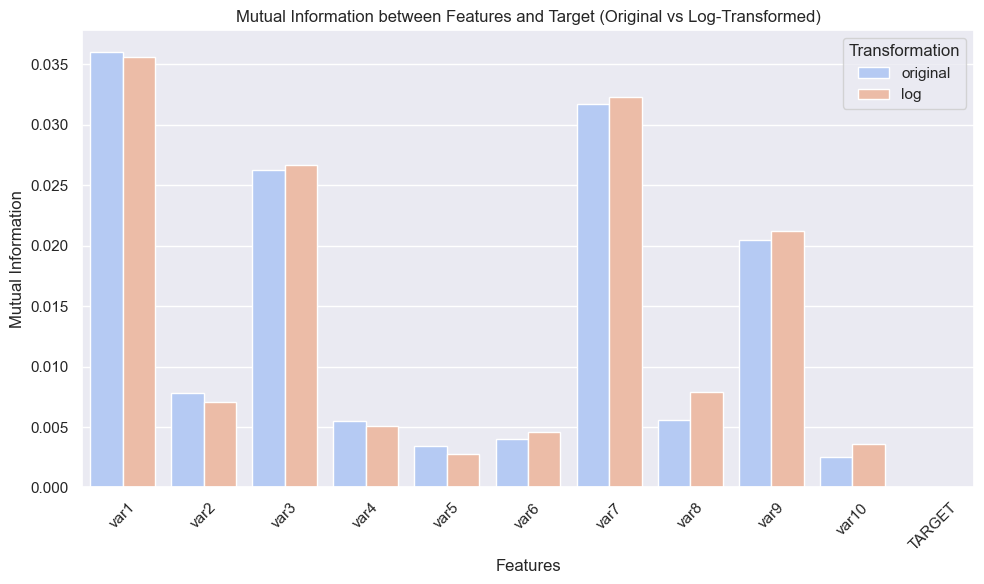

In [22]:
mi_matrix_t = mi_matrix.T
mi_matrix_log_t = mi_matrix_log.T

mi_matrix_t.columns = ['original']
mi_matrix_log_t.columns = ['log']

mi_combined = pd.merge(mi_matrix_t, mi_matrix_log_t, left_index=True, right_index=True)

# Convert to long format for sns.barplot()
mi_combined_melted = mi_combined.reset_index().melt(id_vars='index', var_name='Transformation', value_name='Mutual Information')
mi_combined_melted = mi_combined_melted.rename(columns={'index': 'Feature'})

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=mi_combined_melted, x='Feature', y='Mutual Information', hue='Transformation', palette='coolwarm')

plt.title('Mutual Information between Features and Target (Original vs Log-Transformed)')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Using the logaritmic scale might for helping the model to learn the data better.It is also more robust to outliers, which are abundant in this dataset.

However, we need to be careful with which variable we use the logaritmic scale.

The outliers are a important issue in this dataset, which might decrease the performance of the model, yet they are also important to predict the target.

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 

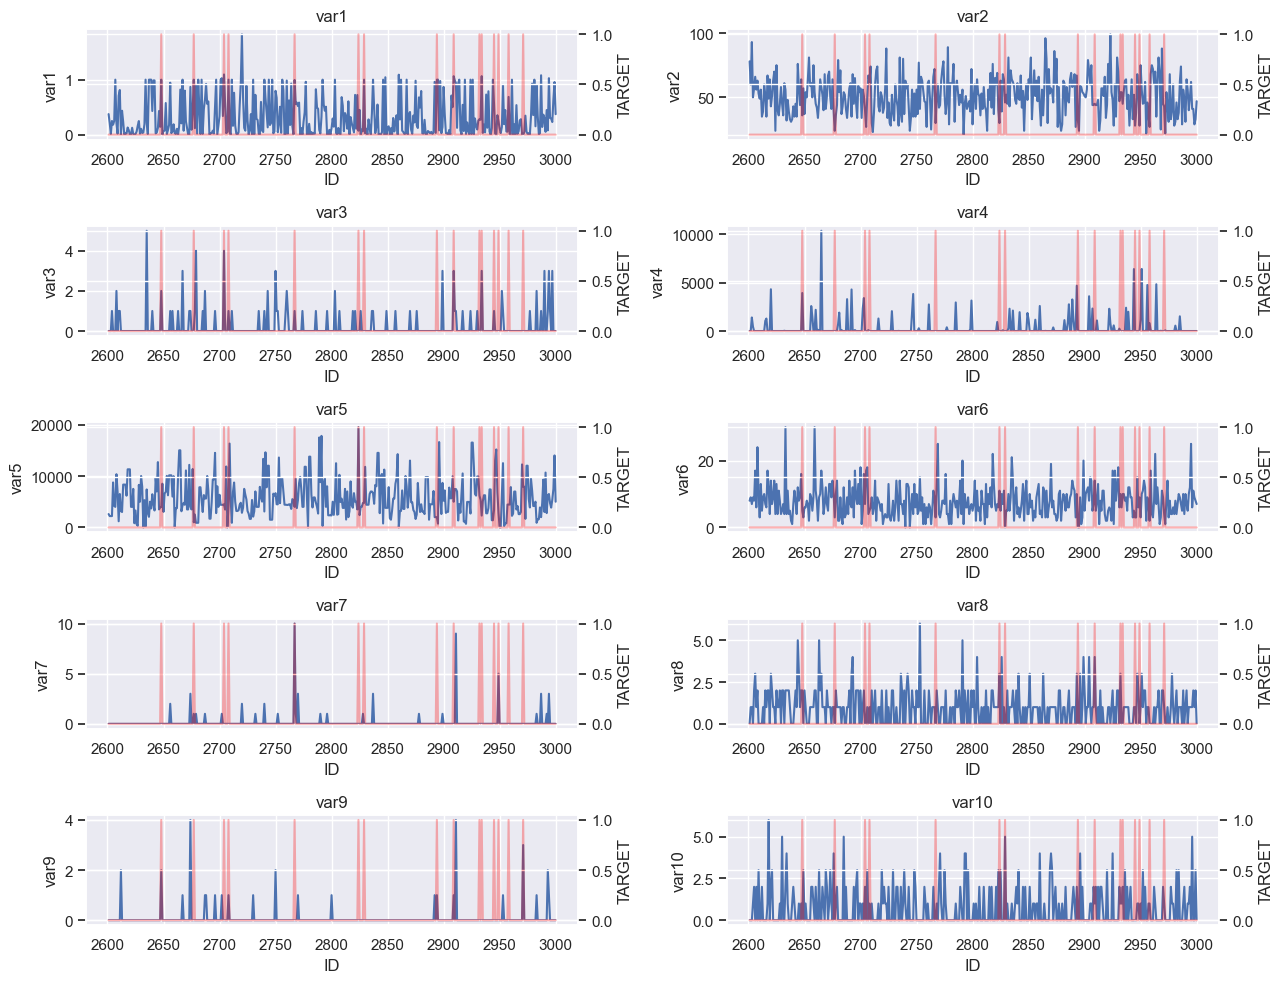

In [23]:
min_idx = 2600
max_idx = 3000

plt.figure(figsize=(13, 10))
for i, col in enumerate(df.columns):
    if col == 'TARGET':
        continue
    print(col, end=" ")
    ax1 = plt.subplot(5, 2, i+1)
    sns.lineplot(data=df.iloc[min_idx:max_idx], x=df.index[min_idx:max_idx], y=col, ax=ax1)
    ax2 = ax1.twinx()
    sns.lineplot(data=df.iloc[min_idx:max_idx], x=df.index[min_idx:max_idx], y='TARGET', alpha=0.3, color='red', ax=ax2)
    plt.title(col)
plt.tight_layout()
plt.show()

In here we can see that the outliers are correlated to the target, so we need to be careful when handling them.

I will create a modified dataset to test afterwards if the logaritmic scale helps the model to learn the data better, **and** if treating the outliers with statistical methods helps the model to learn the data better.

In [24]:
#### LOG #####

df_log = df.copy()
for col in df_log.columns:
    if col == 'TARGET':
        continue
    elif df_log[col].min() < 1e-9:
        df_log[col] = np.log1p(df_log[col])
    else:
        df_log[col] = np.log(df_log[col])
        
df_log.to_csv(os.path.join('data', 'train_log.csv'))

### Outliers

#### IQR

In [25]:
def replace_outliers_iqr (data, columns):
    df_clean = data.copy()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Replace outliers with lower bound
        # df_clean[col] = np.where(df[col] < lower_bound, lower_bound, df[col])
        df_clean[col] = np.where(df[col] > upper_bound, upper_bound, df_clean[col])
    
    return df_clean

#### Percentile 99%

In [26]:
def replace_outliers_percentile(df, columns, upper = 0.99):
    df_clean = df.copy()
    
    for col in columns:
        upper_bound = df[col].quantile(upper)
        df_clean[col] = np.where(df[col] > upper_bound, upper_bound, df_clean[col])

    return df_clean

#### Graphs to visualize the outliers

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 

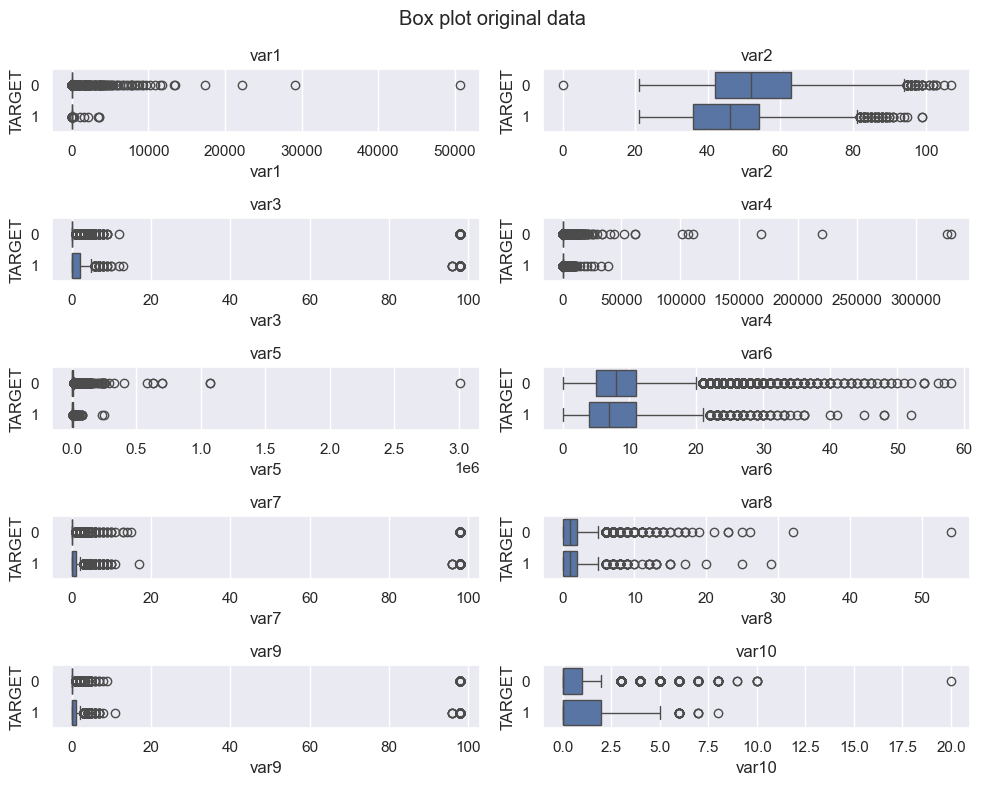

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 

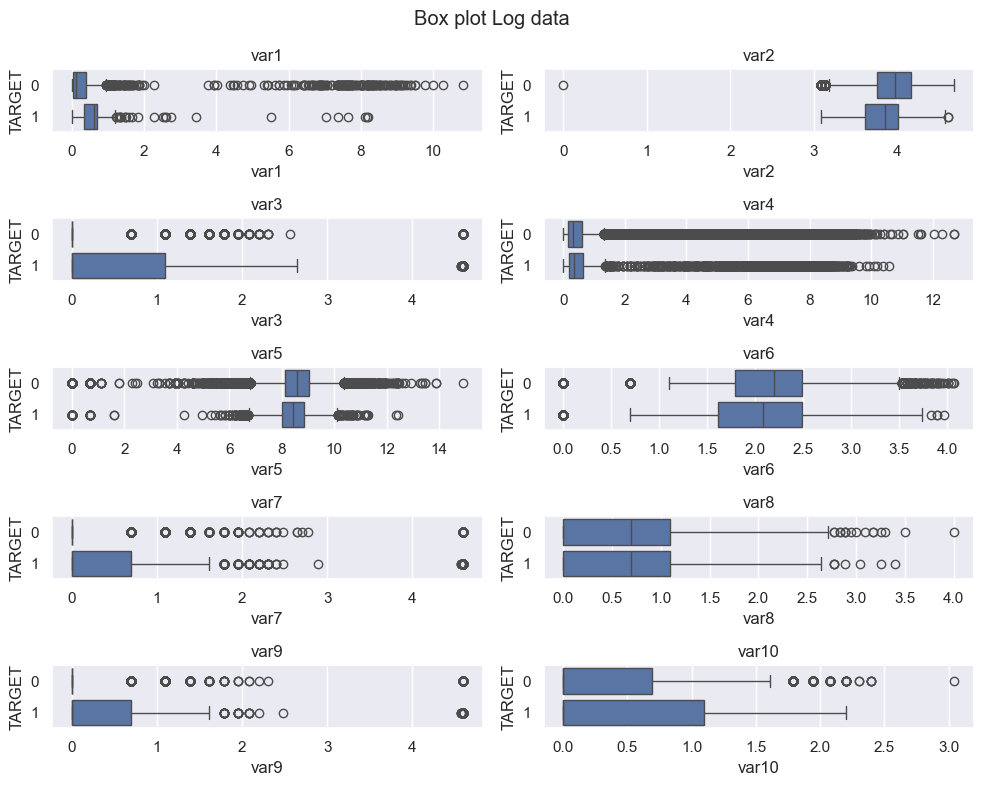

In [27]:
plt.figure(figsize=(10, 8))
plt.suptitle('Box plot original data')
for i, col in enumerate(df.columns):
    if col == 'TARGET':
        continue
    print(col, end = " ")
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x = df[col], y = df['TARGET'], orient='h')
    plt.title(col)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
plt.suptitle('Box plot Log data')
for i, col in enumerate(df.columns):
    if col == 'TARGET':
        continue
    print(col, end = " ")
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x = df_log[col], y = df_log['TARGET'], orient='h')
    plt.title(col)
plt.tight_layout()
plt.show()

The log scale might help the model to learn. It doesnt require much outleir treatment.

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 

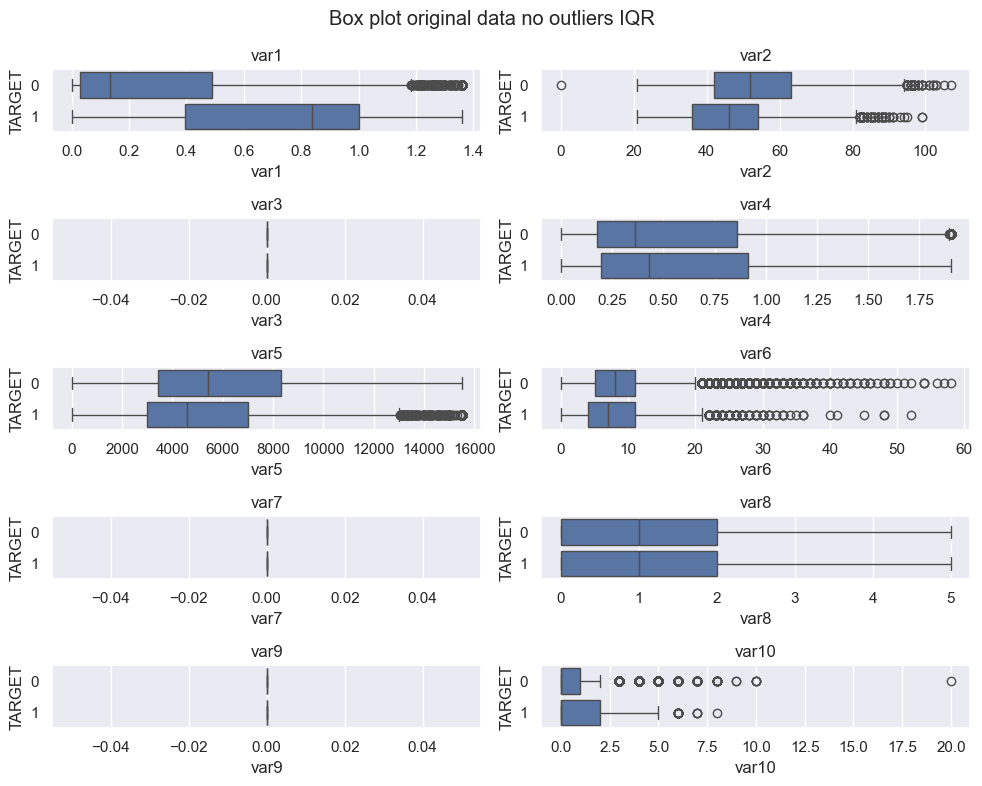

In [28]:
features_2_clean = ['var1', 'var3', 'var4', 'var5', 'var7', 'var8', 'var9',] 
df_clean = replace_outliers_iqr(df, features_2_clean)

plt.figure(figsize=(10, 8))
plt.suptitle('Box plot original data no outliers IQR')
for i, col in enumerate(df_clean.columns):
    if col == 'TARGET':
        continue
    print(col, end = " ")
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x = df_clean[col], y = df_clean['TARGET'], orient='h')
    plt.title(col)
plt.tight_layout()
plt.show()

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 

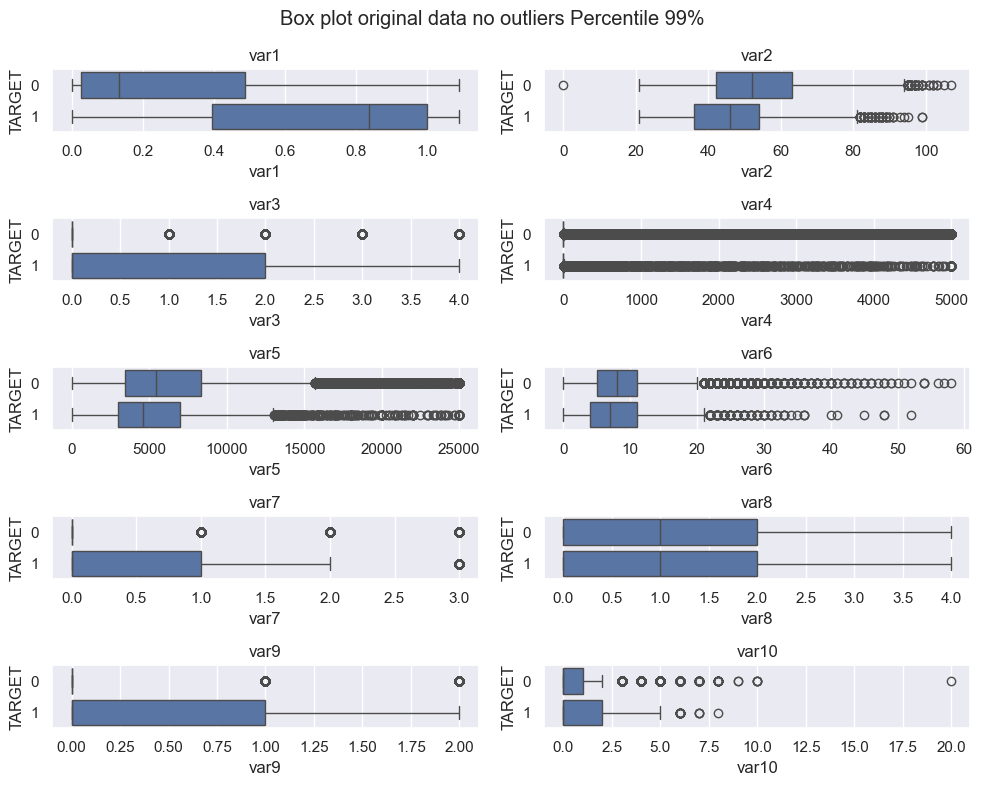

In [29]:
features_2_clean = ['var1', 'var3', 'var4', 'var5', 'var7', 'var8', 'var9',] 
df_clean = replace_outliers_percentile(df, features_2_clean, upper = 0.99)

plt.figure(figsize=(10, 8))
plt.suptitle('Box plot original data no outliers Percentile 99%')
for i, col in enumerate(df_clean.columns):
    if col == 'TARGET':
        continue
    print(col, end = " ")
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x = df_clean[col], y = df_clean['TARGET'], orient='h')
    plt.title(col)
plt.tight_layout()
plt.show()

Given the fact that in `var3`, `var7`, `var9`, the percentile 75% is at 0, then everything non-zero is an outlier.

We can mix both approaches

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 

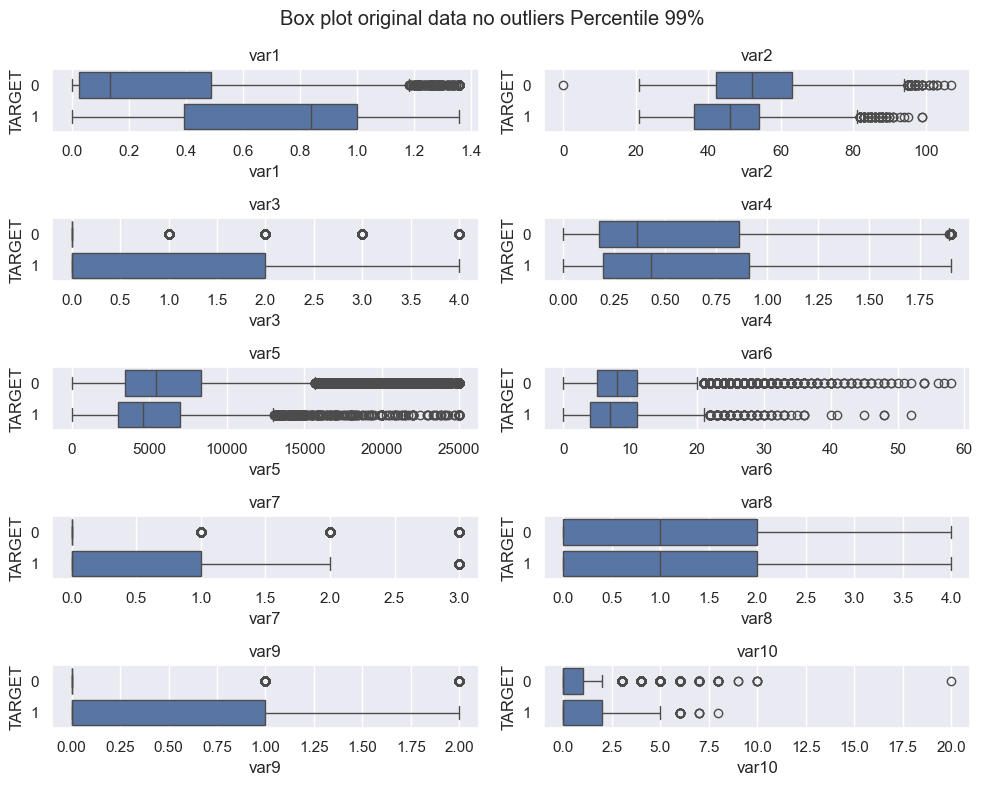

In [30]:
features_2_clean = ['var3', 'var5', 'var7', 'var8', 'var9',] 
df_clean = replace_outliers_percentile(df, features_2_clean, upper = 0.99)

features_2_clean = ['var1', 'var4'] 
df_clean = replace_outliers_iqr(df_clean, features_2_clean)

plt.figure(figsize=(10, 8))
plt.suptitle('Box plot original data no outliers Percentile 99%')
for i, col in enumerate(df_clean.columns):
    if col == 'TARGET':
        continue
    print(col, end = " ")
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x = df_clean[col], y = df_clean['TARGET'], orient='h')
    plt.title(col)
plt.tight_layout()
plt.show()

However, we are lossing important information by changing the value of the outlier.

We can create a **one-hot encoding** for the outliers. And even more, use the log-scale.

In [31]:
def replace_outliers_iqr_one_hot_encoding(data, columns):
    df_clean = data.copy()
    outlier_flags = pd.DataFrame(0, index=data.index, columns=[f"{col}_outlier" for col in columns])  # Initialize flag matrix
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Outlier flag
        outlier_flags[f"{col}_outlier"] = (df_clean[col] > upper_bound).astype(int) # we only care for the upper bound

        # Replace outliers
        df_clean[col] = np.where(df[col] > upper_bound, upper_bound, df_clean[col])
        # quick reminder np.where(condition, value if true, value if false)

    df_clean = pd.concat([df_clean, outlier_flags], axis=1)
    return df_clean

def replace_outliers_percentile_one_hot_encoding(df, columns, upper=0.99):
    df_clean = df.copy()
    outlier_flags = pd.DataFrame(0, index=df.index, columns=[f"{col}_outlier" for col in columns])  # Initialize flag matrix
    
    for col in columns:
        upper_bound = df[col].quantile(upper)

        # Outlier flag
        outlier_flags[f"{col}_outlier"] = (df[col] > upper_bound).astype(int)

        # Replace outliers
        df_clean[col] = np.where(df[col] > upper_bound, upper_bound, df_clean[col])

    df_clean = pd.concat([df_clean, outlier_flags], axis=1)
    return df_clean

In [32]:
features_2_clean = ['var3', 'var5', 'var7', 'var8', 'var9',] 
df_clean = replace_outliers_percentile_one_hot_encoding(df, features_2_clean, upper = 0.99)

features_2_clean = ['var1', 'var4'] 
df_clean = replace_outliers_iqr_one_hot_encoding(df_clean, features_2_clean)

df_clean.head()

var1  var2  var3      var4     var5  var6  var7  var8  var9  var10  \
ID                                                                           
1   0.766127    45   2.0  0.802982   9120.0    13   0.0   4.0   0.0    2.0   
2   0.957151    40   0.0  0.121876   2600.0     4   0.0   0.0   0.0    1.0   
3   0.658180    38   1.0  0.085113   3042.0     2   1.0   0.0   0.0    0.0   
4   0.233810    30   0.0  0.036050   3300.0     5   0.0   0.0   0.0    0.0   
5   0.907239    49   1.0  0.024926  25000.0     7   0.0   1.0   0.0    0.0   

    TARGET  var3_outlier  var5_outlier  var7_outlier  var8_outlier  \
ID                                                                   
1        1             0             0             0             1   
2        0             0             0             0             0   
3        0             0             0             0             0   
4        0             0             0             0             0   
5        0             0             1             0             0   

    var9_outlier  var1_outlier  var4_outlier  
ID                                            
1              0             0             0  
2              0             0             0  
3              0             0             0  
4              0             0             0  
5              0             0             0

In [33]:
df_clean.to_csv(os.path.join('data', 'train_clean.csv'))

If to the no-outlier data set we apply the logarithm, we get:

var1 var2 var3 var4 var5 var6 var7 var8 var9 var10 

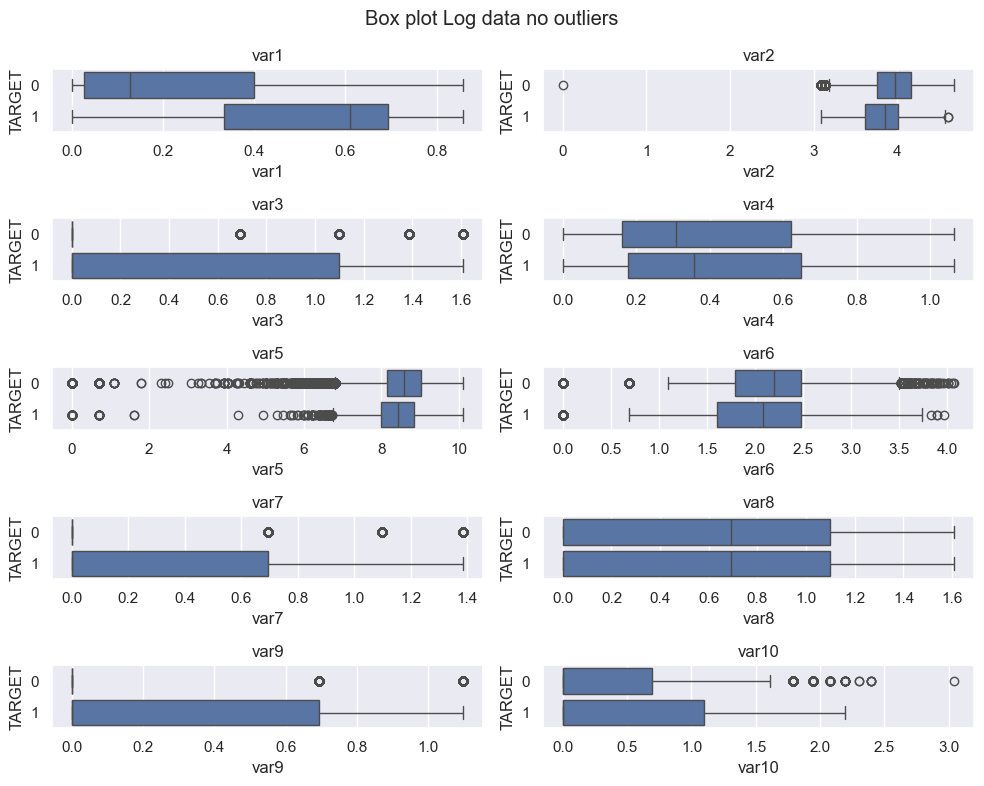

In [34]:
#### LOG #####

df_clean_log = df_clean.copy()
for col in df_clean_log.columns:
    if col == 'TARGET' or 'outlier' in col:
        continue
    elif df_clean_log[col].min() < 1e-9:
        df_clean_log[col] = np.log1p(df_clean_log[col])
    else:
        df_clean_log[col] = np.log(df_clean_log[col])
        
        
plt.figure(figsize=(10, 8))
plt.suptitle('Box plot Log data no outliers')
for i, col in enumerate(df_clean_log.columns):
    if col == 'TARGET' or 'outlier' in col:
        continue
    print(col, end = " ")
    plt.subplot(5, 2, i + 1)
    sns.boxplot(x = df_clean_log[col], y = df_clean_log['TARGET'], orient='h')
    plt.title(col)
plt.tight_layout()
plt.show()

In [35]:
df_clean_log.to_csv(os.path.join('data', 'train_clean_log.csv'))

#### Another measure of outliers using AutoEncoder

I want to reduce the dimension of the features and then try to rebuild them to the original data. The MSE to the original data will be a measure of how much the data is an outlier.

In [36]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.utils import Progbar

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import mean_squared_error

# only grow GPU memory when needed
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
os.environ['TF_USE_LEGACY_KERAS'] = 'True'

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

Autoencoder arquitecture

In [37]:
def autoenconder_model_gen (input_dim, bottleneck_dim, use_bias = True):
    from tensorflow.keras.layers import Activation, BatchNormalization
    from tensorflow.keras.activations import swish
    from tensorflow.keras.models import Model
    
    input_layer = Input(shape=(input_dim,), name='encoder_input')
    
    encoder = Dense(6, use_bias=use_bias)(input_layer)
    #encoder = BatchNormalization()(encoder)
    #encoder = Dropout(0.2)(encoder)
    encoder = Activation(swish)(encoder)
    
    encoder = Dense(4, use_bias=use_bias)(encoder)
    #encoder = BatchNormalization()(encoder)
    #encoder = Dropout(0.2)(encoder)
    encoder = Activation(swish)(encoder)
        
    bottleneck = Dense(bottleneck_dim, activation="linear", use_bias=use_bias)(encoder)
    
    decoder = Dense(4, use_bias=use_bias)(bottleneck)
    decoder = Activation(swish)(decoder)
    
    decoder = Dense(6, use_bias=use_bias)(decoder)
    decoder = Activation(swish)(decoder)
    
    decoder = Dense(input_dim, activation="linear", use_bias=use_bias)(decoder)
    
    autoencoder = Model(input_layer, decoder)
    encoder_model = Model(input_layer, bottleneck)
    
    return autoencoder, encoder_model

model_ae, _ = autoenconder_model_gen(input_dim = 10, bottleneck_dim = 2, use_bias = False)
model_ae.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            60 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184 (736.00 B)

 Trainable params: 184 (736.00 B)

 Non-trainable params: 0 (0.00 B)

Im going to scale the features, since im not prediction. This is to make the model learn better.

In [38]:
try: 
    del autoencoder, encoder
except:
    pass

use_loaded_model = True
use_bias = False
epochs = 30
batch_size = 64
bottleneck_dim = 1
OPT = Adam(learning_rate=0.001)

X = df.drop(columns='TARGET').copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X, index=df.index)

X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42, shuffle=True)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42, shuffle=True)

input_dim = X_train.shape[1]

if os.path.exists('autoencoder_1_model.keras') and use_loaded_model:
    autoencoder_1 = tf.keras.models.load_model('autoencoder_1_model.keras')
    encoder_1 = tf.keras.models.load_model('encoder_1_model.keras')
else:
    autoencoder_1, encoder_1 = autoenconder_model_gen(input_dim, bottleneck_dim, use_bias=use_bias)
    autoencoder_1.compile(optimizer=OPT, loss='mse')
    autoencoder_1.fit(
        X_train, X_train, epochs = epochs, batch_size = batch_size,
        validation_data=(X_val, X_val),
        callbacks=[lr_scheduler, es]
    )
    
    plt.figure(figsize=(5, 3))
    plt.plot(autoencoder_1.history.history['loss'], label='train')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.show()
    
    autoencoder_1.save('autoencoder_1_model.keras')
    encoder_1.save('encoder_1_model.keras')

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


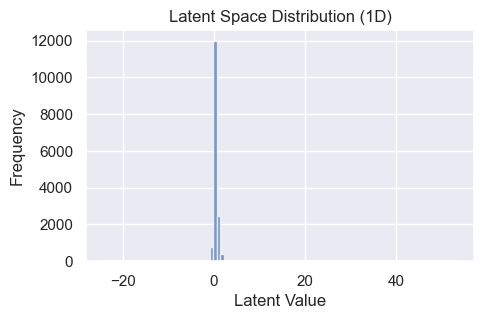

In [39]:
latent_space = encoder_1.predict(X_test)
plt.figure(figsize=(5, 3))
plt.hist(latent_space, alpha=0.7, bins=100)
plt.title("Latent Space Distribution (1D)")
plt.xlabel("Latent Value")
plt.ylabel("Frequency")
plt.show()

Quick reminder of $R^2$:

\begin{equation}
    R^2 = 1 - \frac{\Sigma||Y- \hat{Y}||^2_F}{\Sigma||Y- Y_{mean}||^2_F} = 1 - \frac{RSS}{TSS}
\end{equation}

RSS is the residual sum of squares and TSS is the total sum of squares.

In [40]:
def output_reconstruction_error (model, data, display = True):
    
    recoded_data = model.predict(data)
    mse = mean_squared_error(data, recoded_data)
    
    y = data
    y_mean = data.mean(axis=0)
    TSS = (np.square( y - y_mean ) ).sum(axis=1).sum()
    RSS = (np.square( y - recoded_data ) ).sum(axis=1).sum()
    
    R2 = 1 - RSS/TSS    
    
    if display:
        print(f"Mean Squared Error: {mse}")
        print(f"R-Squared: {R2}")
        
output_reconstruction_error(autoencoder_1, X_test)

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error: 0.6935358795301421
R-Squared: 0.4556987820814634


In [41]:
try: 
    del autoencoder_2, encoder_2
except:
    pass

use_loaded_model = True
use_bias = False
epochs = 30
batch_size = 128
bottleneck_dim = 2
OPT = Adam(learning_rate=0.001)


X = df.drop(columns='TARGET').copy()

scaler_ae_2 = StandardScaler()
X = scaler_ae_2.fit_transform(X)

X = pd.DataFrame(X, index=df.index)

X_train, X_temp = train_test_split(X, test_size=0.3, random_state=42)
X_val, X_test = train_test_split(X_temp, test_size=0.5, random_state=42)

input_dim = X_train.shape[1]

if os.path.exists('autoencoder_2_model.keras') and use_loaded_model:
    autoencoder_2 = tf.keras.models.load_model('autoencoder_2_model.keras')
    encoder_2 = tf.keras.models.load_model('encoder_2_model.keras')
else:
    autoencoder_2, encoder_2 = autoenconder_model_gen(input_dim, bottleneck_dim, use_bias=use_bias)
    autoencoder_2.compile(optimizer=OPT, loss='mse')
    autoencoder_2.fit(
        X_train, X_train, epochs = epochs, batch_size = batch_size,
        validation_data=(X_val, X_val),
        callbacks=[lr_scheduler, es]
    )
    
    plt.figure(figsize=(5, 3))
    plt.plot(autoencoder_2.history.history['loss'], label='train')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.show()
    
    autoencoder_2.save('autoencoder_2_model.keras')
    encoder_2.save('encoder_2_model.keras')

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Mean Squared Error: 0.49528378639768145
R-Squared: 0.6112911009965332


<Figure size 500x300 with 0 Axes>

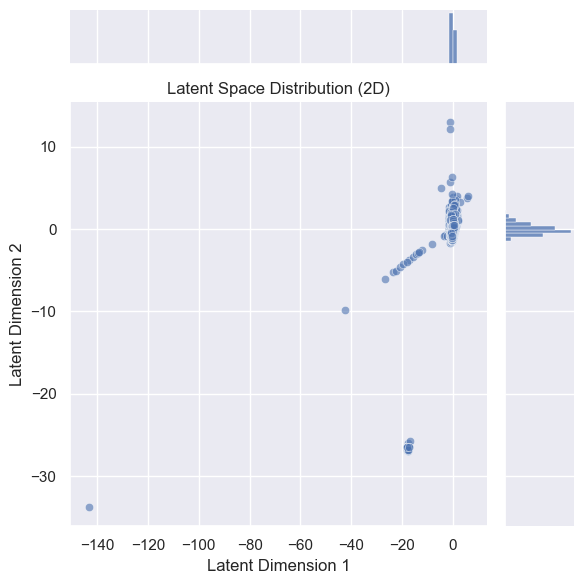

In [42]:
latent_space = encoder_2.predict(X_test)
x, y = latent_space[:, 0], latent_space[:, 1]

output_reconstruction_error(autoencoder_2, X_test)

plt.figure(figsize=(5, 3))
sns.jointplot(
    x=x, y=y, 
    kind="scatter", 
    height=6,
    alpha=0.6,
    marginal_kws={'bins': 100, 'fill': True}, 
)
plt.title("Latent Space Distribution (2D)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.tight_layout()
plt.show()

In [43]:
def compute_squared_errors(model, data):
    data_recreated = model.predict(data)
    errors = np.sum( np.square(data - data_recreated), axis=1 ) 
    return errors

In [44]:
errors_2 = compute_squared_errors(autoencoder_2, X_test)
data_2 = pd.DataFrame({'errors' : errors_2, 'TARGET' : df.loc[X_test.index, 'TARGET']}, index = X_test.index)

errors_1 = compute_squared_errors(autoencoder_1, X_test)
data_1 = pd.DataFrame({'errors' : errors_1, 'TARGET' : df.loc[X_test.index, 'TARGET']}, index = X_test.index)

493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
493/493 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


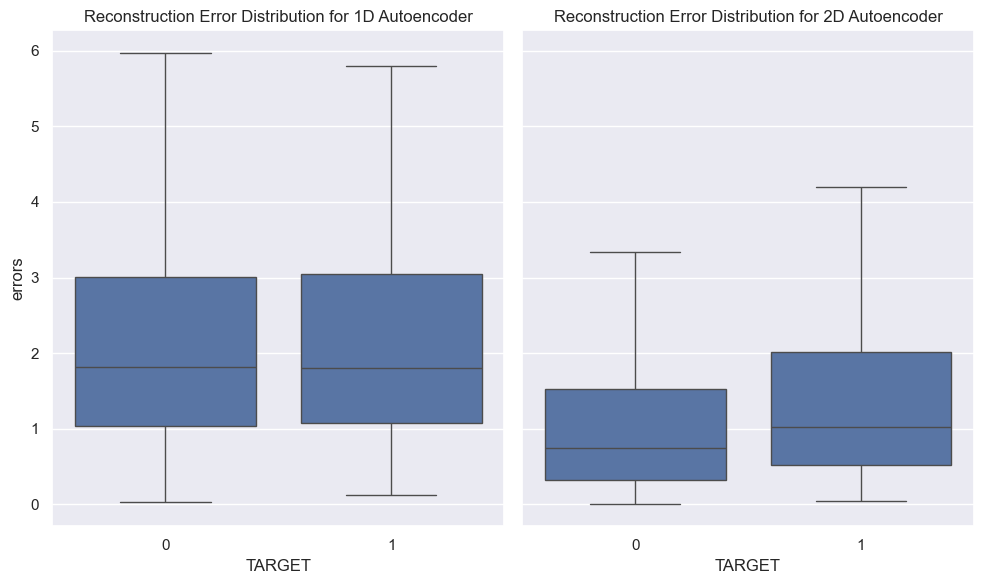

In [45]:
fig, axes = plt.subplots(1, 2, sharey=True, figsize=(10, 6))

sns.boxplot(x='TARGET', y='errors', data=data_1, showfliers=False, ax=axes[0])
axes[0].set_title('Reconstruction Error Distribution for 1D Autoencoder')

sns.boxplot(x='TARGET', y='errors', data=data_2, showfliers=False, ax=axes[1])
axes[1].set_title('Reconstruction Error Distribution for 2D Autoencoder')

plt.tight_layout()
plt.show()

Lets create the new feature that is the error of the autoencoder trying to rebuild the data.

Due that it takes some time, I won't perform the best way to get the errors for the dataset. Ideally, I would traing the neural network with $2/3$ of the data set, and do some cross validation to get the entire dataset error for the autoencoder without using the train parameters for obtaining the new feature.

In [46]:
df_errors = df.copy()

errors = compute_squared_errors(autoencoder_2, X)
df_errors['error'] = errors

3282/3282 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [47]:
mi_matrix = pd.DataFrame(columns=df_errors.columns)

for col1 in df_errors.columns:
    if col1 == 'TARGET':
        continue
    mi = mutual_info_classif(df_errors[[col1]].values.reshape(-1, 1), df_errors['TARGET'])
    mi_matrix[col1] = mi

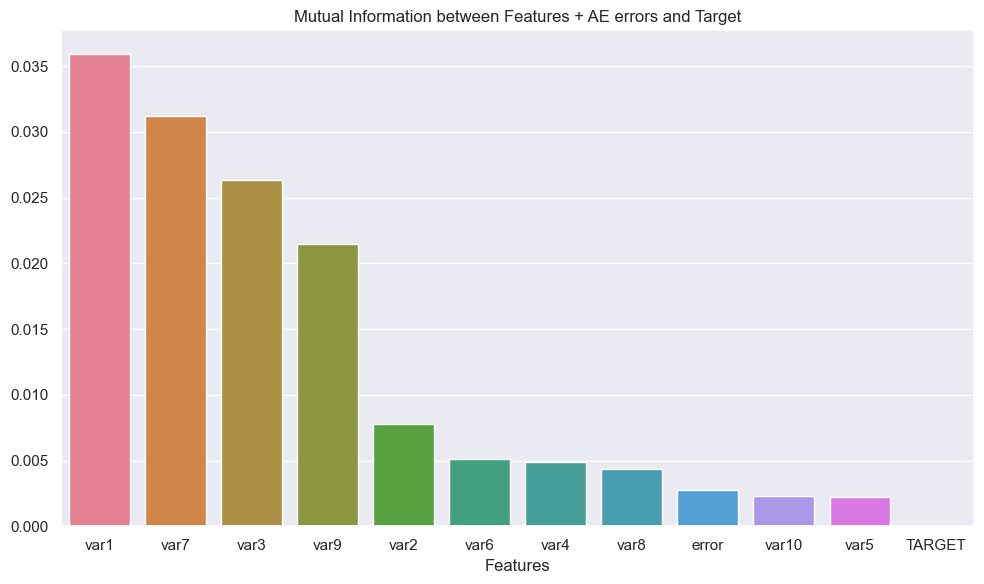

In [48]:
plt.figure(figsize=(10, 6))
plt.title('Mutual Information between Features + AE errors and Target')
sns.barplot(data=mi_matrix.T.sort_values(by=0, ascending=False).T)
plt.xlabel('Features')
plt.tight_layout()
plt.show()

The error is not a significant feature, but it might help the model to learn the data better.

In [49]:
df_errors[['error']].to_csv(os.path.join('data', 'train_errors.csv'))

### Feature extration by clustering

I want to see if the data groups in **clusters**, which i can classify afterwards and
use it as a new feature, being the state of the market.

#### PCA

In [50]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

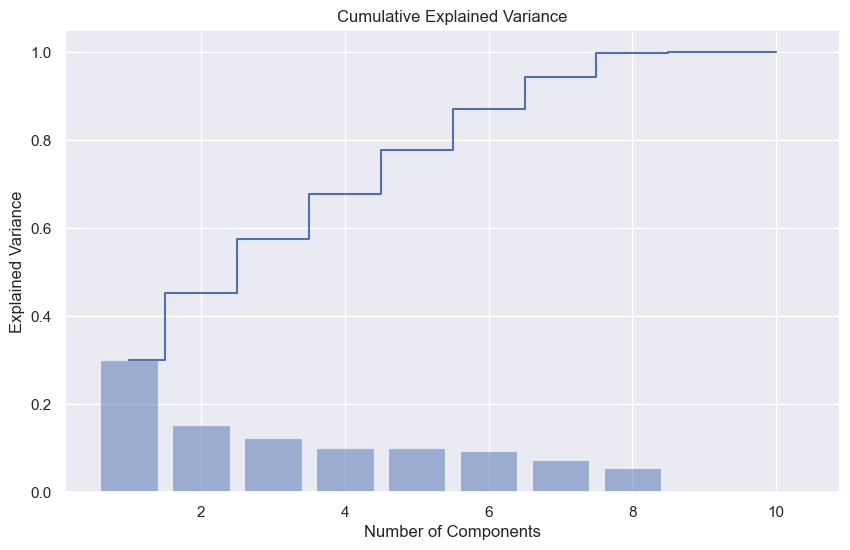

In [51]:
X = df.drop(columns='TARGET').copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X)

explained_variance = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10, 6))
plt.step(range(1, len(explained_variance) + 1), cumulative_explained_variance, where='mid')
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')
plt.show()

In here is just wanted to know if there are some unuseful dimension, something
classic to do in ML, however i do believe that those 2 dimension are important in 
the right timing.

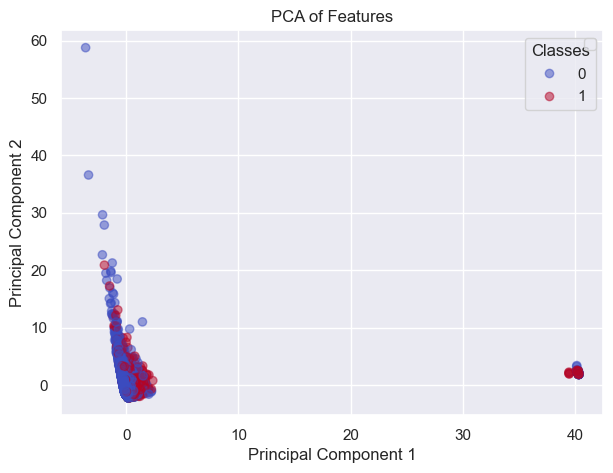

In [52]:
X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
legend1 = plt.legend(*scatter.legend_elements(), title='Classes')
plt.gca().add_artist(legend1)
plt.title('PCA of Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

There are no clear clusters, so we will not use PCA for feature extraction.

This leads us to think that we need to search for non linear relationships.

Some techniques for dimension reduction are:

- PCA focuses on maximizing variance but can lose non-linear structures.
- t-SNE captures local neighborhoods well but distorts global structure.
- UMAP preserves both local and global structures better than t-SNE, making it highly useful for clustering and visualization.
- Autoencoders can learn non-linear structures and are useful for anomaly detection.

In [53]:
import umap

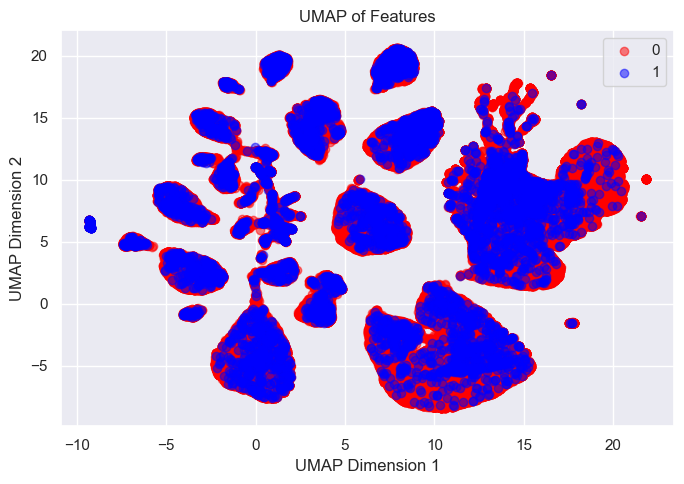

In [54]:
X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X)

umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'], index=df.index)

plt.scatter(umap_df.loc[y == 0, 'UMAP1'], umap_df.loc[y == 0, 'UMAP2'], color='red', label='0', alpha=0.5)
plt.scatter(umap_df.loc[y == 1, 'UMAP1'], umap_df.loc[y == 1, 'UMAP2'], color='blue', label='1', alpha=0.5)
plt.title('UMAP of Features')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

We can see some clear clusters, so we will use UMAP for feature extraction.

Now we need to decide how to cluster the data. We can use 

- Kmeans 
- DBSCAN 
- HDBSCAN.

#### Kmeans

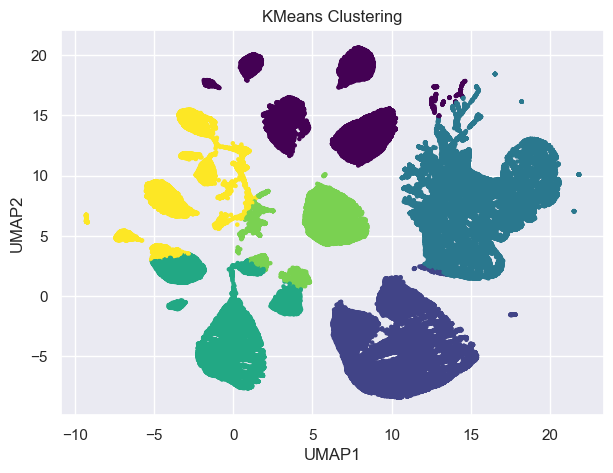

In [55]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters = 6, random_state=42)
kmeans_labels = kmeans.fit_predict(X_umap)

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=kmeans_labels, cmap='viridis', s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('KMeans Clustering')
plt.show()

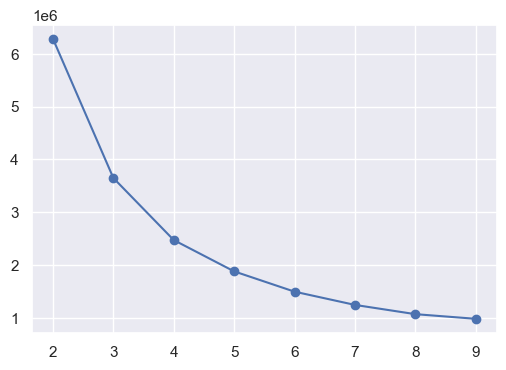

In [56]:
df_kmeans = df.copy()

inertia_values = []
for clusters in range(2, 10):
    kmeans = KMeans(n_clusters = clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_umap)
    df_kmeans[f'kmeans_{clusters}'] = kmeans_labels
    inertia_values.append(kmeans.inertia_) 

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), inertia_values, marker='o', linestyle='-')
plt.show()

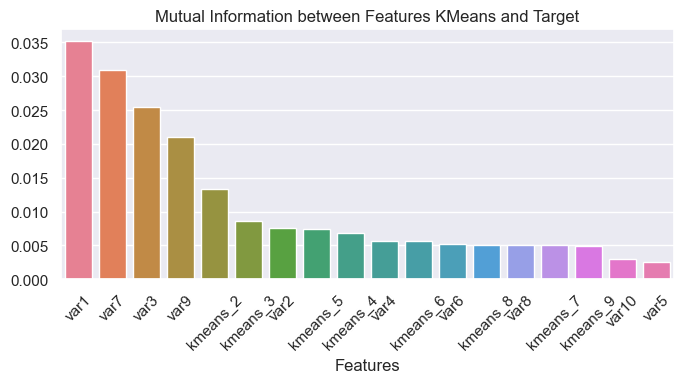

In [57]:
def mutual_info_features(data, target, title=""):
    mi_matrix = pd.DataFrame(columns=data.columns)
    for col1 in data.columns:
        mi = mutual_info_classif(data[[col1]].values.reshape(-1, 1), target)
        mi_matrix[col1] = mi
    mi_matrix = mi_matrix.T.sort_values(by=0, ascending=False).T
    
    plt.figure(figsize=(7, 4))
    plt.title(f'Mutual Information between Features {title} and Target')
    sns.barplot(data=mi_matrix.T.sort_values(by=0, ascending=False).T)
    plt.xlabel('Features')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
mutual_info_features(df_kmeans.drop(columns='TARGET'), df_kmeans['TARGET'], title='KMeans')

Im going to use XGBoost as a way to see the weights of the features. 
Since from the graph, it seems that the clusters are better with less clusters.

In [58]:
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix

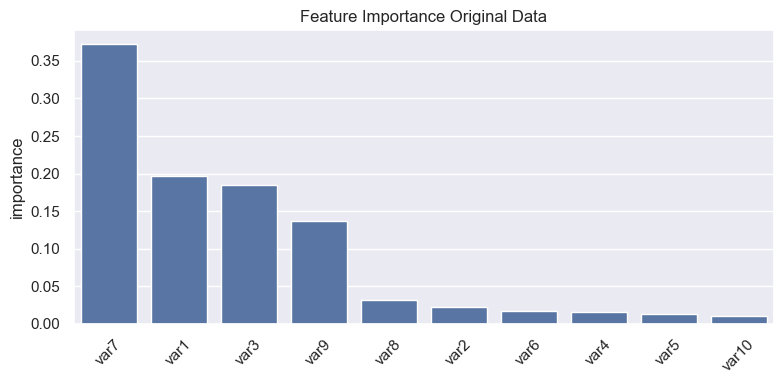

In [59]:
def xgb_features(data, target, random_state=42, title="Data"):
    
    params = {
        'max_depth': 3,
        'n_estimators': 500,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'scale_pos_weight': 3.5,
        'colsample_bytree': 0.8,
        'seed': random_state,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }
    
    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(data, target)
    
    feature_importance = xgb_model.feature_importances_
    importance_df = pd.DataFrame(feature_importance, index=data.columns, columns=['importance'])
    importance_df = importance_df.sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(8, 4))
    sns.barplot(importance_df['importance'])
    plt.title(f'Feature Importance {title}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

xgb_features(X, y, title="Original Data")

100%|===================| 104964/104998 [20:10<00:00]        

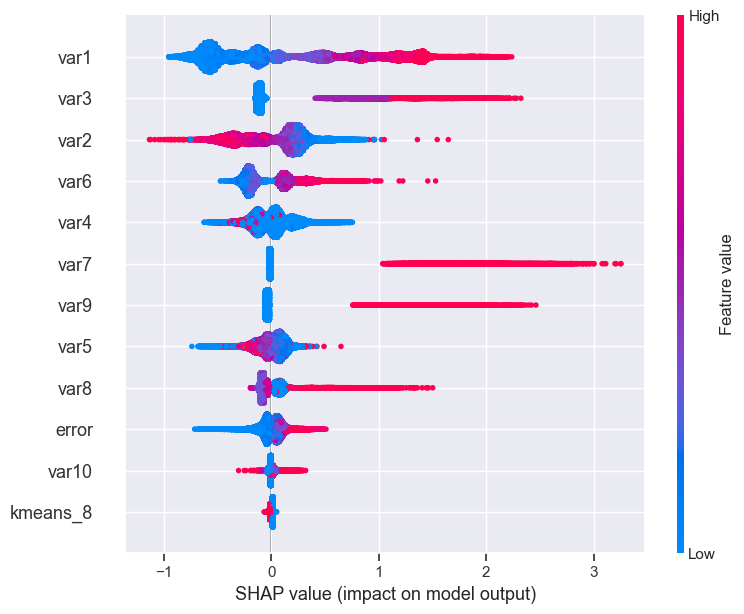

In [92]:
import shap

def xgb_shap_values(data, target, random_state=42, title="Data"):
    params = {
        'max_depth': 3,
        'n_estimators': 500,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'scale_pos_weight': 3.5,
        'colsample_bytree': 0.8,
        'seed': random_state,
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
    }

    xgb_model = xgb.XGBClassifier(**params)
    xgb_model.fit(data, target)
    
    # Compute SHAP values
    explainer = shap.Explainer(xgb_model, data)
    shap_values = explainer(data)
    
    # Plot summary
    shap.summary_plot(shap_values, data)

X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

xgb_shap_values(X, y, title="Original Data")

Interesting to see that the information and the feature importance by the xgboost are very similar.

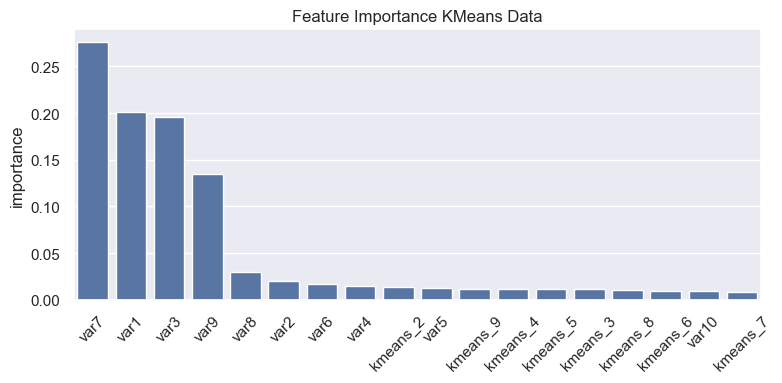

In [60]:
X = df_kmeans.drop(columns='TARGET').copy()
y = df_kmeans['TARGET'].copy()

xgb_features(X, y, title="KMeans Data")

As expected, the kmeans doesnt provide as much information as expected.

**The best is 4 means**

What if we let xgboost decide if they are significative or not?

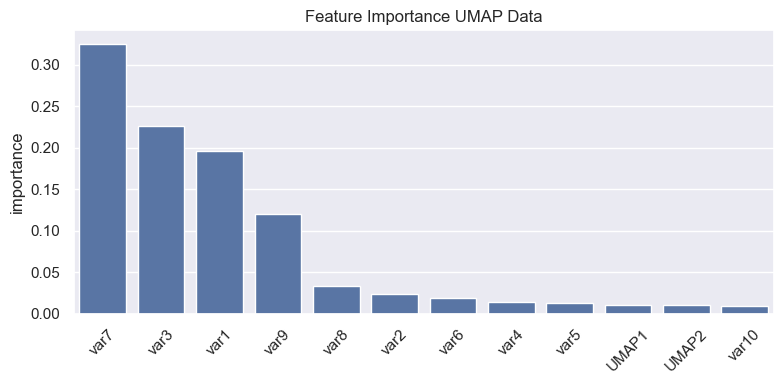

In [61]:
df_umap = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'], index=df.index)
X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

X = pd.concat([X, df_umap], axis=1)
xgb_features(X, y, title="UMAP Data")

Not important

#### DBScan

15


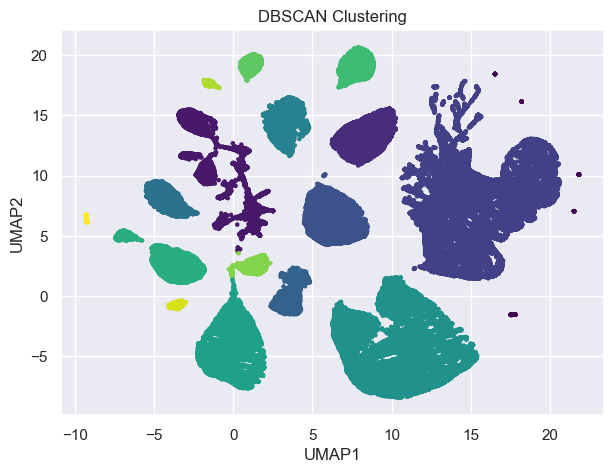

In [62]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import calinski_harabasz_score

dbscan = DBSCAN(eps=1.0, min_samples=150)
dbscan_labels = dbscan.fit_predict(X_umap)

print(np.max(dbscan_labels))

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=dbscan_labels, cmap='viridis', s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('DBSCAN Clustering')
plt.show()

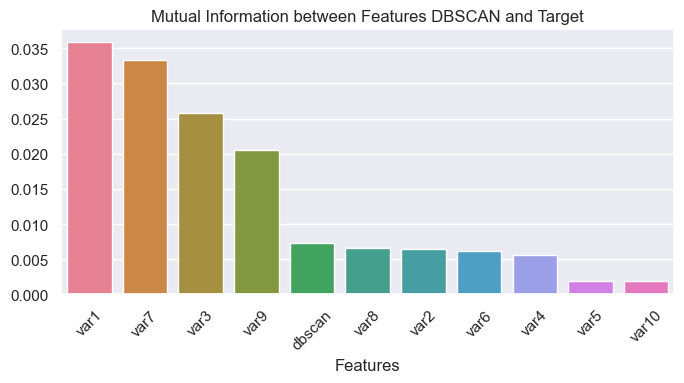

In [63]:
df_dbscan = df.copy()
df_dbscan['dbscan'] = dbscan_labels
mutual_info_features(df_dbscan.drop(columns='TARGET'), df_dbscan['TARGET'], title='DBSCAN')

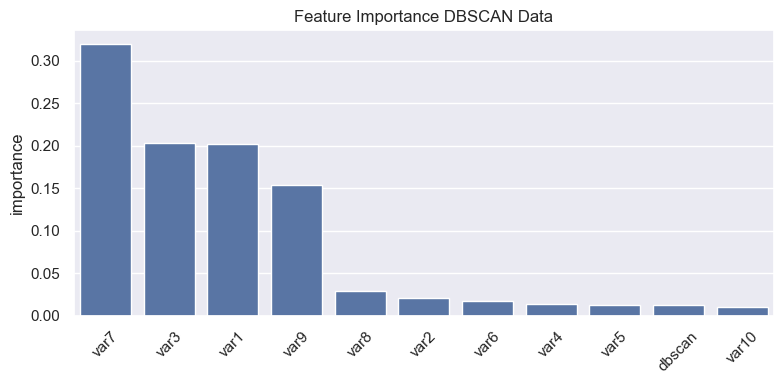

In [64]:
xgb_features(df_dbscan.drop(columns='TARGET'), df_dbscan['TARGET'], title="DBSCAN Data")

Using XGboost is not that useful.

#### HDBSCAN

24


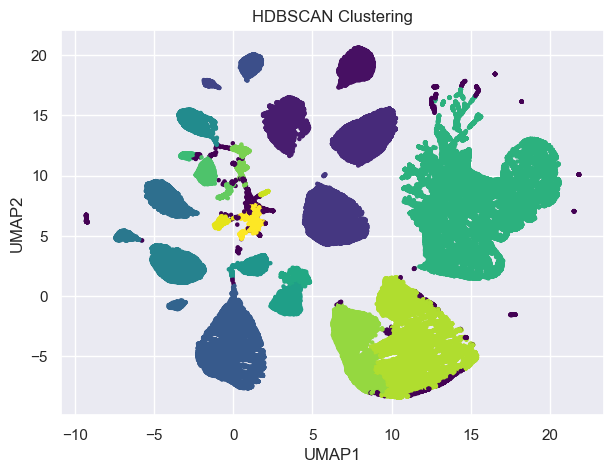

In [65]:
import hdbscan

hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=250)
hdbscan_labels = hdbscan_clusterer.fit_predict(X_umap)

print(np.max(hdbscan_labels))

plt.scatter(X_umap[:, 0], X_umap[:, 1], c=hdbscan_labels, cmap='viridis', s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('HDBSCAN Clustering')
plt.show()

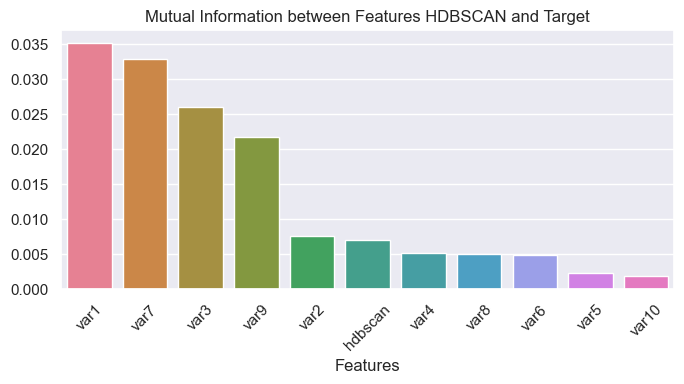

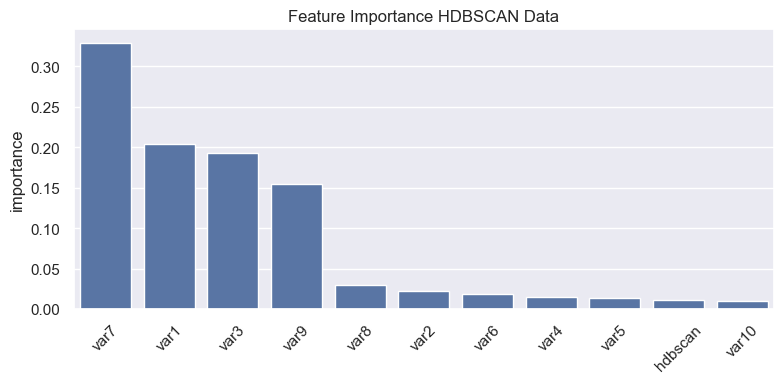

In [66]:
df_hdbscan = df.copy()
df_hdbscan['hdbscan'] = hdbscan_labels

mutual_info_features(df_hdbscan.drop(columns='TARGET'), df_hdbscan['TARGET'], title='HDBSCAN')
xgb_features(df_hdbscan.drop(columns='TARGET'), df_hdbscan['TARGET'], title="HDBSCAN Data")

#### Autoencoder

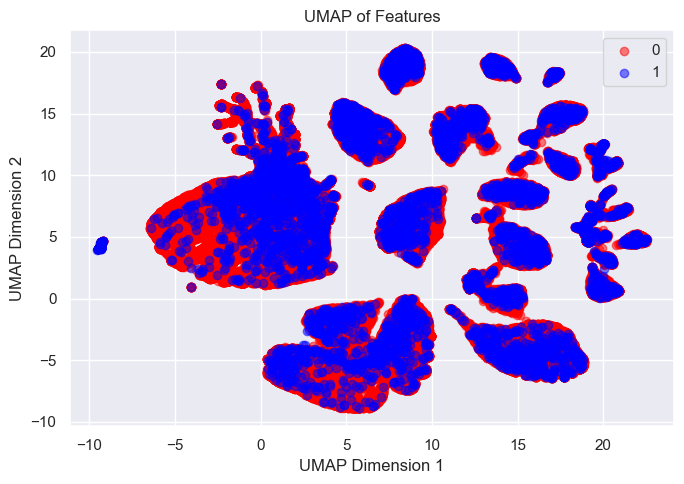

In [67]:
X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

scaler = StandardScaler()
X = scaler.fit_transform(X)

umap_model = umap.UMAP(n_components=2)
X_umap = umap_model.fit_transform(X)

umap_df = pd.DataFrame(X_umap, columns=['UMAP1', 'UMAP2'], index=df.index)

plt.scatter(umap_df.loc[y == 0, 'UMAP1'], umap_df.loc[y == 0, 'UMAP2'], color='red', label='0', alpha=0.5)
plt.scatter(umap_df.loc[y == 1, 'UMAP1'], umap_df.loc[y == 1, 'UMAP2'], color='blue', label='1', alpha=0.5)
plt.title('UMAP of Features')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.legend()
plt.tight_layout()
plt.show()

In [68]:
X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

latent_space = encoder_2.predict(X)

3282/3282 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step


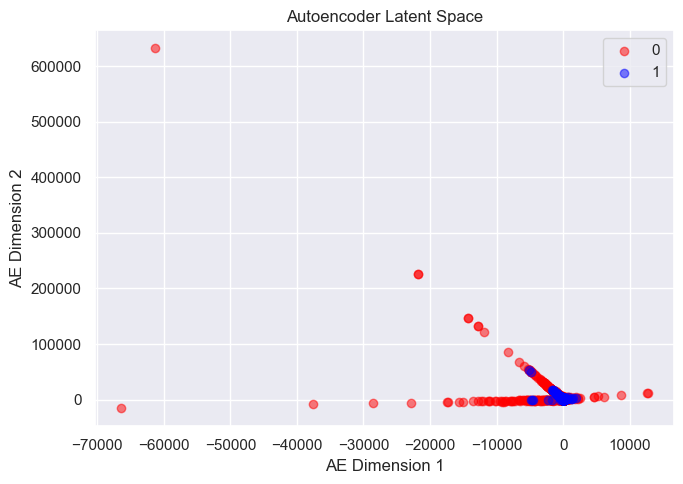

In [69]:
latent_space.shape
ae_df = pd.DataFrame(latent_space, columns=[f'AE_{i}' for i in range(latent_space.shape[1])], index=df.index)

plt.scatter(ae_df.loc[y == 0, 'AE_0'], ae_df.loc[y == 0, 'AE_1'], color='red', label='0', alpha=0.5)
plt.scatter(ae_df.loc[y == 1, 'AE_0'], ae_df.loc[y == 1, 'AE_1'], color='blue', label='1', alpha=0.5)
plt.title('Autoencoder Latent Space')
plt.xlabel('AE Dimension 1')
plt.ylabel('AE Dimension 2')
plt.tight_layout()
plt.legend()
plt.show()

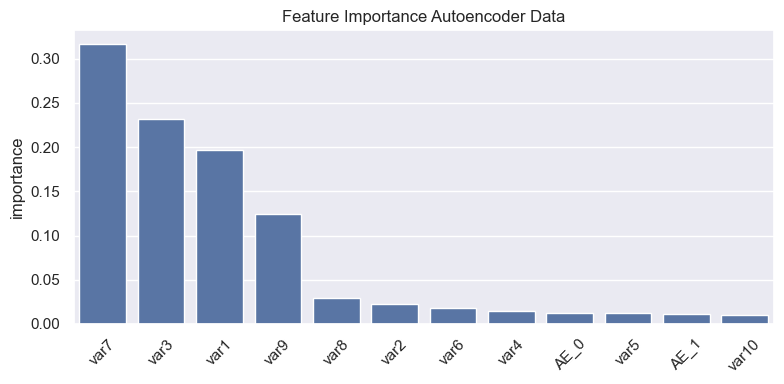

In [70]:
X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

X = pd.concat([X, ae_df], axis=1)
xgb_features(X, y, title="Autoencoder Data")

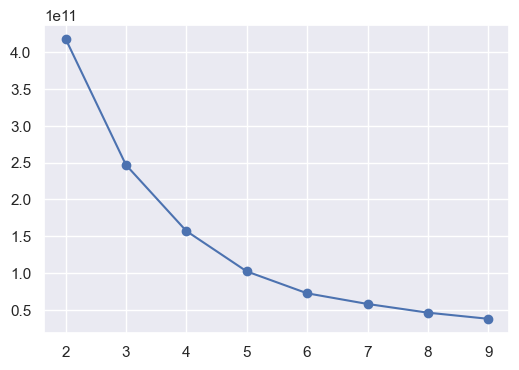

In [71]:
df_kmeans = df.copy()
kmeans_ae_dict = {}

inertia_values = []
for clusters in range(2, 10):
    kmeans = KMeans(n_clusters = clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(latent_space)
    df_kmeans[f'kmeans_{clusters}'] = kmeans_labels
    inertia_values.append(kmeans.inertia_) 
    kmeans_ae_dict[clusters] = kmeans

# Plot the Elbow Curve
plt.figure(figsize=(6, 4))
plt.plot(range(2, 10), inertia_values, marker='o', linestyle='-')
plt.show()

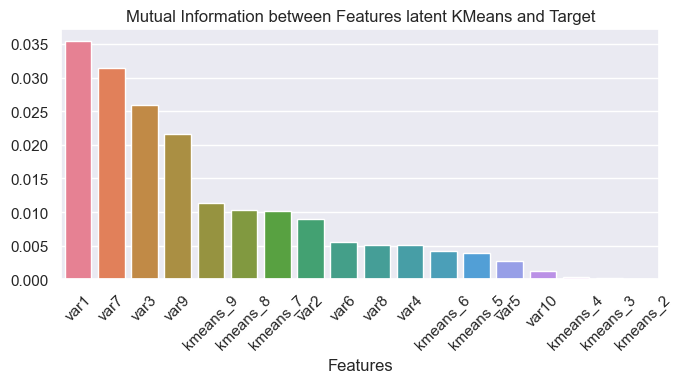

In [72]:
mutual_info_features(df_kmeans.drop(columns='TARGET'), df_kmeans['TARGET'], title='latent KMeans')

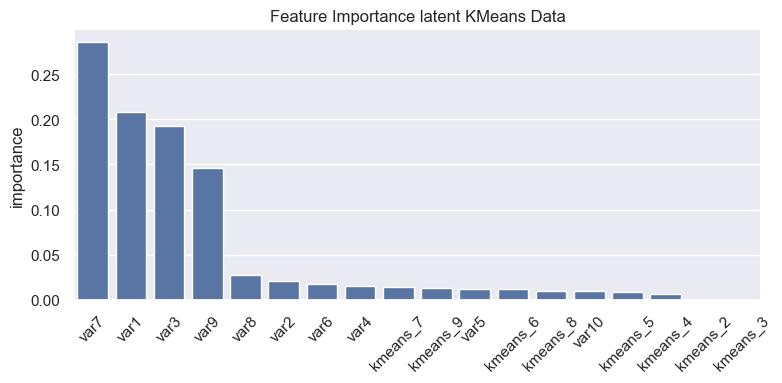

In [73]:
xgb_features(df_kmeans.drop(columns='TARGET'), df_kmeans['TARGET'], title="latent KMeans Data")

59


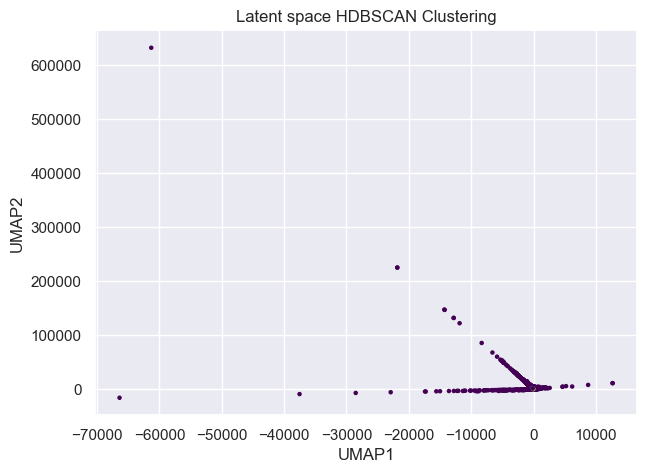

In [74]:
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=300)
hdbscan_labels = hdbscan_clusterer.fit_predict(latent_space)

print(np.max(hdbscan_labels))

plt.scatter(latent_space[:, 0], latent_space[:, 1], c=hdbscan_labels, cmap='viridis', s=5)
plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('Latent space HDBSCAN Clustering')
plt.show()

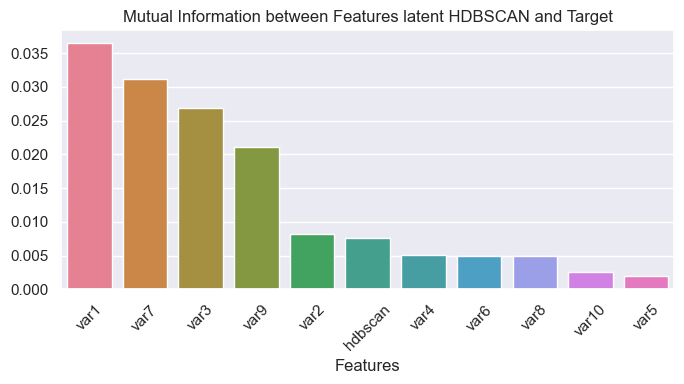

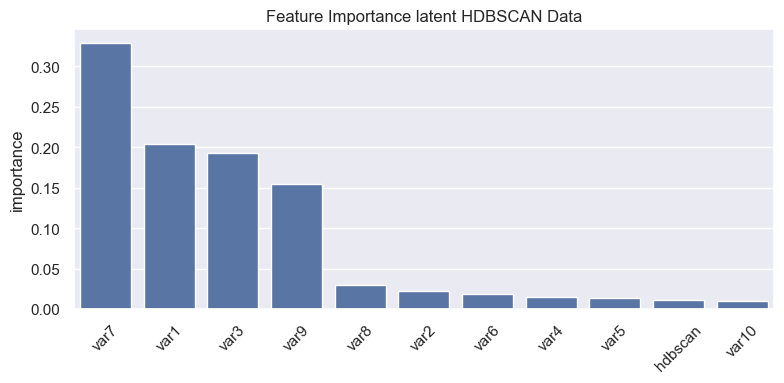

In [75]:
mutual_info_features(df_hdbscan.drop(columns='TARGET'), df_hdbscan['TARGET'], title='latent HDBSCAN')
xgb_features(df_hdbscan.drop(columns='TARGET'), df_hdbscan['TARGET'], title="latent HDBSCAN Data")

Im going to save kmeans 8 since is the best one.

In [76]:
df_kmeans[['kmeans_8']].to_csv(os.path.join('data', 'train_kmeans.csv'))

## Model selection

Given the nature of the problem, which is a **binary classification** and the fact that the dataset is **unbalanced**, the bests models to my knowledge are:

- XGBoost
- LightGBM
- Random Forest
- Logistic Regression
- Neural Networks

The data is **not linear**, so logistic regression is not a good choice.

We have a fairly **big dataset**, so using Random forest is not adviced.

We can use Neural networks or XGBoost. The models that made me score the 
best was XGBoost. It is fairly simple, fast and can be high tuned easily.

### XGBoost

Im going to use the errors from the autoencoder as a new feature and the kmeans clusters.

In [77]:
df = pd.read_csv(os.path.join('data', 'train.csv'), index_col='ID')
df.loc[:, 'var10'] = df.loc[:, 'var10'].fillna(df.loc[:, 'var10'].median())
df.loc[:, 'var5'].ffill(inplace=True)

df_errors = pd.read_csv(os.path.join('data', 'train_errors.csv'), index_col='ID')
df_kmeans = pd.read_csv(os.path.join('data', 'train_kmeans.csv'), index_col='ID')

df = pd.concat([df, df_errors, df_kmeans], axis=1)
df.head()

var1  var2  var3      var4     var5  var6  var7  var8  var9  var10  \
ID                                                                           
1   0.766127    45     2  0.802982   9120.0    13     0     6     0    2.0   
2   0.957151    40     0  0.121876   2600.0     4     0     0     0    1.0   
3   0.658180    38     1  0.085113   3042.0     2     1     0     0    0.0   
4   0.233810    30     0  0.036050   3300.0     5     0     0     0    0.0   
5   0.907239    49     1  0.024926  63588.0     7     0     1     0    0.0   

    TARGET      error  kmeans_8  
ID                               
1        1   6.837677         6  
2        0   0.217656         0  
3        0   0.111089         0  
4        0   0.360228         0  
5        0  19.384422         3

I will define the XGBoost in a function to make it easier to tune.

In [78]:
""" def xgboost_parameter_selection (X, y, params, cv = 4, title="", random_state = 42):
    import xgboost as xgb
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    clf = xgb.XGBClassifier()
    grid_search = GridSearchCV(estimator=clf, param_grid=params, scoring='f1', cv=cv, verbose=1, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_clf = grid_search.best_estimator_

    y_pred = best_clf.predict(X_test)

    # Results
    print("Best parameters found: ", grid_search.best_params_)
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("f1-score", f1_score(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(2, 2))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # feature importance
    feature_importance = pd.DataFrame(index=X.columns)
    feature_importance['importance'] = best_clf.feature_importances_
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=feature_importance.T, orient='h')
    plt.title(f'Feature Importance {title}')
    plt.show() """

' def xgboost_parameter_selection (X, y, params, cv = 4, title="", random_state = 42):\n    import xgboost as xgb\n    from sklearn.model_selection import train_test_split, GridSearchCV\n    from sklearn.metrics import f1_score, accuracy_score, confusion_matrix\n    \n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)\n    \n    clf = xgb.XGBClassifier()\n    grid_search = GridSearchCV(estimator=clf, param_grid=params, scoring=\'f1\', cv=cv, verbose=1, n_jobs=-1)\n    grid_search.fit(X_train, y_train)\n\n    best_clf = grid_search.best_estimator_\n\n    y_pred = best_clf.predict(X_test)\n\n    # Results\n    print("Best parameters found: ", grid_search.best_params_)\n    print("Accuracy", accuracy_score(y_test, y_pred))\n    print("f1-score", f1_score(y_test, y_pred))\n\n    # Confusion Matrix\n    plt.figure(figsize=(2, 2))\n    cm = confusion_matrix(y_test, y_pred)\n    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels

Best parameters found:  {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 600, 'reg_alpha': 1, 'reg_lambda': 4, 'scale_pos_weight': 4, 'subsample': 0.7}

In [79]:
""" param_grid = {
    'max_depth': [3],
    'learning_rate': [0.05],
    'n_estimators': [600],
    'scale_pos_weight' : [3, 3.5, 4],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'gamma': [0.1],
    'min_child_weight': [5],
    'reg_alpha': [1],
    'reg_lambda': [4]
}

X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

xgboost_parameter_selection(X, y, param_grid, cv=4, title="Original Data + Errors + KMeans") """

' param_grid = {\n    \'max_depth\': [3],\n    \'learning_rate\': [0.05],\n    \'n_estimators\': [600],\n    \'scale_pos_weight\' : [3, 3.5, 4],\n    \'subsample\': [0.7],\n    \'colsample_bytree\': [0.7],\n    \'gamma\': [0.1],\n    \'min_child_weight\': [5],\n    \'reg_alpha\': [1],\n    \'reg_lambda\': [4]\n}\n\nX = df.drop(columns=\'TARGET\').copy()\ny = df[\'TARGET\'].copy()\n\nxgboost_parameter_selection(X, y, param_grid, cv=4, title="Original Data + Errors + KMeans") '

In [80]:
def xgboost_bayesian_parameter_selection (X, y, params, cv = 4, n_iter = 30, title="", random_state = 42):
    import xgboost as xgb
    from sklearn.model_selection import train_test_split, GridSearchCV
    from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
    from skopt import BayesSearchCV
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    clf = xgb.XGBClassifier()
    bayes_search = BayesSearchCV(
        estimator=clf,
        search_spaces=params,
        scoring='f1',
        cv=cv,
        n_jobs=-1,
        n_iter=n_iter,   
        verbose=1
    )
    bayes_search.fit(X_train, y_train)

    best_clf = bayes_search.best_estimator_

    y_pred = best_clf.predict(X_test)

    # Results
    print("Best parameters found: ", bayes_search.best_params_)
    print("Accuracy", accuracy_score(y_test, y_pred))
    print("f1-score", f1_score(y_test, y_pred))

    # Confusion Matrix
    plt.figure(figsize=(2, 2))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    # feature importance
    feature_importance = pd.DataFrame(index=X.columns)
    feature_importance['importance'] = best_clf.feature_importances_
    feature_importance = feature_importance.sort_values(by='importance', ascending=False)

    plt.figure(figsize=(8, 5))
    sns.barplot(data=feature_importance.T, orient='h')
    plt.title(f'Feature Importance {title}')
    plt.show()
    
    return best_clf

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

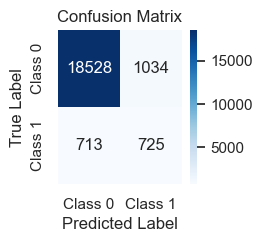

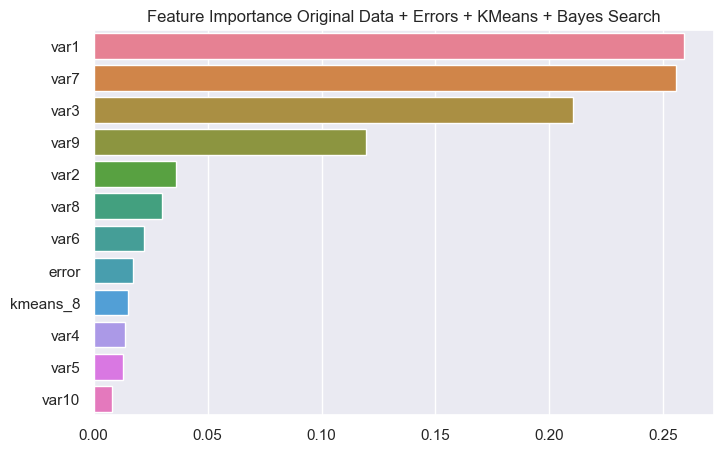

In [81]:
param_grid = {
    'n_estimators': (500, 550),
    'learning_rate': (0.01, 0.03),
    'max_depth': (3, 4),
    'min_child_weight': (1, 3),
    'gamma': (0.4, 0.8),
    'subsample': (0.8, 1.0),
    'colsample_bytree': (0.6, 0.8),
    'lambda': (1, 10),
    'alpha': (1, 10),
    'scale_pos_weight' : (3, 5),
}

df = pd.read_csv(os.path.join('data', 'train.csv'), index_col='ID')
df.loc[:, 'var10'] = df.loc[:, 'var10'].fillna(df.loc[:, 'var10'].median())
df.loc[:, 'var5'].ffill(inplace=True)

df_errors = pd.read_csv(os.path.join('data', 'train_errors.csv'), index_col='ID')
df_kmeans = pd.read_csv(os.path.join('data', 'train_kmeans.csv'), index_col='ID')

df = pd.concat([df, df_errors, df_kmeans], axis=1)

X = df.drop(columns='TARGET').copy()
y = df['TARGET'].copy()

xgb_model = xgboost_bayesian_parameter_selection(
    X, y, param_grid, cv=5, n_iter=50, title="Original Data + Errors + KMeans + Bayes Search"
)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

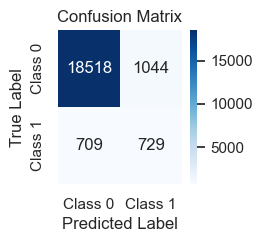

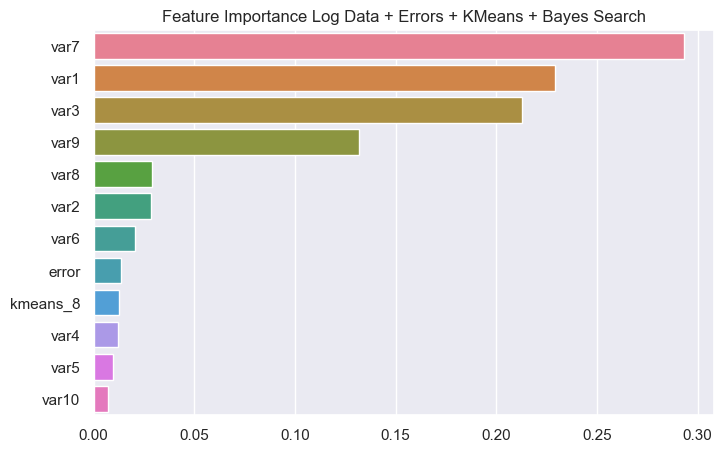

In [82]:
df_log = pd.read_csv(os.path.join('data', 'train_log.csv'), index_col='ID')
df_log.loc[:, 'var10'] = df_log.loc[:, 'var10'].fillna(df_log.loc[:, 'var10'].median())
df_log.loc[:, 'var5'].ffill(inplace=True)

df_errors = pd.read_csv(os.path.join('data', 'train_errors.csv'), index_col='ID')
df_kmeans = pd.read_csv(os.path.join('data', 'train_kmeans.csv'), index_col='ID')

df_log = pd.concat([df_log, df_errors, df_kmeans], axis=1)

X = df_log.drop(columns='TARGET').copy()
y = df_log['TARGET'].copy()

param_grid = {
    'n_estimators': (500, 550),
    'learning_rate': (0.01, 0.03),
    'max_depth': (3, 4),
    'min_child_weight': (1, 3),
    'gamma': (0.4, 0.8),
    'subsample': (0.8, 1.0),
    'colsample_bytree': (0.6, 0.8),
    'lambda': (1, 10),
    'alpha': (1, 10),
    'scale_pos_weight' : (3, 5),
}

xgb_log_model = xgboost_bayesian_parameter_selection(
    X, y, param_grid, cv=5, n_iter=50, title="Log Data + Errors + KMeans + Bayes Search"
)


In [83]:
def submit_solution_ae (model, scaler_ae, kmean, clusters, encoder, autoencoder, name = "output_ae.csv"):
    df_test = pd.read_csv(os.path.join('data', 'test.csv'), index_col=0)
    df_test.loc[:, 'var10'] = df_test.loc[:, 'var10'].fillna(df_test.loc[:, 'var10'].median())
    df_test.loc[:, 'var5'].ffill(inplace=True)
    
    X_test = df_test.copy()
    X_scale = scaler_ae.transform(X_test)

    errors = compute_squared_errors(autoencoder, X_scale)
    df_test['error'] = errors

    latent_space = encoder.predict(X_scale)
    kmeans_labels = kmean.fit_predict(latent_space)
    df_test[f'kmeans_{clusters}'] = kmeans_labels
    df_output = pd.DataFrame(index=df_test.index)
    df_output['TARGET'] = model.predict(df_test)
    df_output.to_csv(os.path.join("data", "output.csv"))
    
scaler_ae = scaler_ae_2
clusters = 8
kmean = kmeans_ae_dict[clusters]
autoencoder = autoencoder_2
encoder = encoder_2

submit_solution_ae(
    xgb_model,
    scaler_ae,
    kmean,
    clusters,
    encoder,
    autoencoder    
)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [84]:
def submit_solution_ae_log (model, scaler_ae, kmean, clusters, encoder, autoencoder, name = "output_ae.csv"):
    df_test = pd.read_csv(os.path.join('data', 'test.csv'), index_col=0)
    df_test.loc[:, 'var10'] = df_test.loc[:, 'var10'].fillna(df_test.loc[:, 'var10'].median())
    df_test.loc[:, 'var5'].ffill(inplace=True)
        
    X_test = df_test.copy()
    X_scale = scaler_ae.transform(X_test)

    errors = compute_squared_errors(autoencoder, X_scale)
    df_test['error'] = errors

    latent_space = encoder.predict(X_scale)
    kmeans_labels = kmean.fit_predict(latent_space)
    df_test[f'kmeans_{clusters}'] = kmeans_labels
    
    for col in df_test.columns:
        if 'var' in col:
            if df_test[col].min() < 1e-9:
                df_test[col] = np.log1p(df_test[col])
            else:
                df_test[col] = np.log(df_test[col])
    
    df_output = pd.DataFrame(index=df_test.index)
    df_output['TARGET'] = model.predict(df_test)
    df_output.to_csv(os.path.join("data", "output_log.csv"))
    
scaler_ae = scaler_ae_2
clusters = 8
kmean = kmeans_ae_dict[clusters]
autoencoder = autoencoder_2
encoder = encoder_2

submit_solution_ae_log(
    xgb_log_model,
    scaler_ae,
    kmean,
    clusters,
    encoder,
    autoencoder    
)

1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


# Tranformers

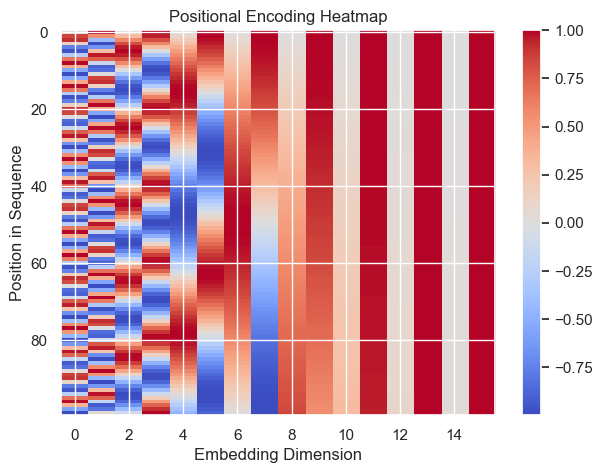

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

def positional_encoding(seq_length, d_model):
    PE = np.zeros((seq_length, d_model))
    for pos in range(seq_length):
        for i in range(0, d_model, 2):  # Even indices use sine, odd indices use cosine
            PE[pos, i] = np.sin(pos / (10000 ** (i / d_model)))
            PE[pos, i+1] = np.cos(pos / (10000 ** (i / d_model)))
    return PE

# Visualizing Positional Encodings
PE = positional_encoding(seq_length=100, d_model=16)
plt.imshow(PE, cmap="coolwarm", aspect="auto")
plt.colorbar()
plt.title("Positional Encoding Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position in Sequence")
plt.show()


In [86]:
df_log = pd.read_csv(os.path.join('data', 'train_log.csv'), index_col='ID')
df_log.loc[:, 'var10'] = df_log.loc[:, 'var10'].fillna(df_log.loc[:, 'var10'].median())
df_log.loc[:, 'var5'] = df_log.loc[:, 'var5'].ffill()

In [87]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch

def create_sequences(df, target_col, window_size):
    X, y = [], []
    for i in range(len(df) - window_size):
        X.append(df.iloc[i:i+window_size].drop(columns=[target_col]).values)
        y.append(df.iloc[i+window_size][target_col])
    return np.array(X), np.array(y)

scaler = StandardScaler()
df_log[df_log.columns.difference(['TARGET'])] = scaler.fit_transform(df_log[df_log.columns.difference(['TARGET'])])

window_size = 15
X, y = create_sequences(df_log, target_col='TARGET', window_size=window_size)


split = int(0.8 * len(X)) 
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


X_train_torch = torch.tensor(X_train, dtype=torch.float32).to('cuda')
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to('cuda')
y_train_torch = torch.tensor(y_train, dtype=torch.float32).to('cuda')
y_test_torch = torch.tensor(y_test, dtype=torch.float32).to('cuda')

In [88]:
import torch.nn as nn

class TimeSeriesTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, window_size):
        super(TimeSeriesTransformer, self).__init__()
        self.model_dim = model_dim

        self.input_embedding = nn.Linear(input_dim, model_dim)
        self.positional_encoding = self.create_positional_encoding(window_size, model_dim)

        encoder_layer = nn.TransformerEncoderLayer(d_model=model_dim, nhead=num_heads, dropout=0.3)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Capa de salida (Clasificación Binaria)
        self.fc = nn.Linear(model_dim, 1)
        self.sigmoid = nn.Sigmoid()
    
    def create_positional_encoding(self, seq_length, model_dim):
        PE = torch.zeros(seq_length, model_dim)
        for pos in range(seq_length):
            for i in range(0, model_dim, 2):
                PE[pos, i] = np.sin(pos / (10000 ** (i / model_dim)))
                PE[pos, i+1] = np.cos(pos / (10000 ** (i / model_dim)))
        return PE.unsqueeze(0)

    def forward(self, x):
        x = self.input_embedding(x)  # (batch, window_size, model_dim)
        x = x + self.positional_encoding[:, :x.shape[1], :].to(x.device)  # Agregar encoding de posición
        x = self.transformer_encoder(x)  # Pasamos por el Transformer
        x = self.fc(x[:, -1, :])  # Tomamos solo el último timestamp
        return self.sigmoid(x)  # Probabilidad binaria

# Definir el modelo
input_dim = X_train.shape[2]  # 10 features
model_dim = 16
num_heads = 2
num_layers = 1
window_size = 15

try:
    del model
except:
    pass
model = TimeSeriesTransformer(input_dim, model_dim, num_heads, num_layers, window_size).to('cuda')
# Calculate and print the number of parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 68,945 trainable parameters


In [89]:
import torch.optim as optim
from sklearn.utils.class_weight import compute_class_weight
import torch.nn.functional as F

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.array([0, 1]), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to("cuda")

# Define weighted BCE loss
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights[1] * 2)  # More weight to minority class
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrenamiento
epochs = 20
batch_size = 32
train_loader = torch.utils.data.DataLoader(list(zip(X_train_torch, y_train_torch)), batch_size=batch_size, shuffle=True)

for epoch in range(epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    

Epoch 1/20, Loss: 0.7199
Epoch 2/20, Loss: 1.2540
Epoch 3/20, Loss: 1.7573
Epoch 4/20, Loss: 0.7277
Epoch 5/20, Loss: 2.2274
Epoch 6/20, Loss: 2.2625
Epoch 7/20, Loss: 1.2216
Epoch 8/20, Loss: 1.2450
Epoch 9/20, Loss: 0.7256
Epoch 10/20, Loss: 0.7295
Epoch 11/20, Loss: 2.2388
Epoch 12/20, Loss: 1.2354
Epoch 13/20, Loss: 1.2447
Epoch 14/20, Loss: 1.2451
Epoch 15/20, Loss: 1.7517
Epoch 16/20, Loss: 1.2255
Epoch 17/20, Loss: 1.2434
Epoch 18/20, Loss: 1.2396
Epoch 19/20, Loss: 1.2373
Epoch 20/20, Loss: 0.7538


In [90]:
with torch.no_grad():
    y_test_pred = model(X_test_torch).squeeze()
    y_test_pred = (y_test_pred > 0.5).float() 

accuracy = (y_test_pred == y_test_torch).float().mean().item()
print(f"Test Accuracy: {accuracy:.2%}")


Test Accuracy: 93.18%


In [91]:
from sklearn.metrics import f1_score

def evaluate_f1_score(model, X_test, y_test):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        y_pred = model(X_test).squeeze()
        y_pred = (y_pred > 0.5).float()  # Convert probabilities to 0 or 1

    # Convert to numpy
    y_pred_np = y_pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()

    # Compute F1-score
    f1 = f1_score(y_test_np, y_pred_np)
    return f1

# Compute F1-score
f1 = evaluate_f1_score(model, X_test_torch, y_test_torch)
print(f"Test F1 Score: {f1:.4f}")


Test F1 Score: 0.0000
